In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from bioinfokit import analys, visuz
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#### Load precomputed Kruskal analysis results ####

results_path = os.path.join('computed_stats', 'kruskal.csv')
alpha = 1e-9

# Load data
results = pd.read_csv(results_path)
results = results.drop(columns = ['Unnamed: 0'])
# Drop STRs where all populations had the same repeat count
results = results.dropna().reset_index(drop=True)

# Correct p-values
results['kruskal_pval_bonf'] = results.kruskal_pval * len(results)
results['kruskal_pval_bonf'].where(results['kruskal_pval_bonf'] < 1, 1, inplace=True)

In [3]:
#### Extract gene information ####

genes = pd.read_csv("Homo_sapiens.GRCh38.108.gtf", sep = "\t", comment="#", header=None)
genes[0] = "chr" + genes[0].astype(str)


def find_genes(row):
    gene_df = genes[(genes[0] == row['chr']) & (genes[3] <= row['pos']) & 
                    (genes[4] >= row['pos'])]
    if len(gene_df) == 0:
        return None
    gene_df_info = gene_df[8].str.split(";")
    gene_set = set()
    for info in list(gene_df_info):
        for field in info:
            if "gene_name" in field:
                name = field.strip().replace("gene_name ","").replace('"','')
                gene_set.add(name)
    if len(gene_set) == 0:
        return None
                
    return ",".join(list(gene_set))

In [90]:
str_data_cache = {}

In [102]:
data_dir_path = 'preprocessed_data'

def find_pop_expansion(chrom, pos):

# Get STR data
    if chrom not in str_data_cache:
        print(chrom)
        str_data = pd.read_csv(os.path.join(data_dir_path, f'{chrom}.csv'))
        str_data_cache[chrom] = str_data.drop_duplicates()
    str_data = str_data_cache[chrom]
    example_data = str_data[str_data.position == pos].iloc[0]

    # Get diffs for each population and make dataframe
    motif_len = example_data.motif_len
    maximums = []
    diffs_dict = {}
    for pop in ['AMR', 'AFR', 'EAS', 'EUR', 'SAS']:
        diffs = example_data[f'diffs_{pop}'].strip(' []').split(',')
        if diffs == ['']:
            return np.nan
        diffs = [int(int(d.strip()) / motif_len) for d in diffs]
        diffs_dict[pop] = diffs
        maximums.append((max(diffs), pop))
    
    maximums.sort(reverse=True)
    if maximums[0][0] < 10:
        return

    counts_5 = len([x for x in diffs_dict[maximums[0][1]] if x >= maximums[0][0] - 5])
    counts_10 = len([x for x in diffs_dict[maximums[0][1]] if x >= maximums[0][0] - 10])
    counts_15 = len([x for x in diffs_dict[maximums[0][1]] if x >= maximums[0][0] - 15])
    counts_mid = len([x for x in diffs_dict[maximums[0][1]] if x >= (maximums[0][0] + maximums[1][0]) / 2])
    
    stats.append([chrom, pos, motif_len, maximums[0][0], 
                  maximums[0][1], maximums[1][0], counts_5, counts_10, counts_15, counts_mid])

In [4]:
###### Computing expansion statistics for each locus ######

# stats = []
# loci = list(zip(results.chr, results.position))
# for i in tqdm(range(len(loci))):
#     find_pop_expansion(loci[i][0], loci[i][1])
    
    
# stats_df = pd.DataFrame(stats, columns = ['chr', 'pos', 'motif', 
#                                           'max_cn', 'max_pop', 'second_cn', 'more_5',
#                                           'more_10', 'more15', 'more_mid'])

# stats_df['dif_cn'] = stats_df['max_cn'] - stats_df['second_cn']
# stats_df.to_csv("expansion_stats.csv", index=False, sep = "\t")

stats_df = pd.read_csv("expansion_stats.csv", sep = "\t")

# Final table

expansions = stats_df[(stats_df['dif_cn'] >= 15) & (stats_df['more_mid'] > 10)].sort_values('dif_cn')

def aggregate_info(row):
    expansion_dict = {}
    mid = int((row['max_cn'] + row['second_cn'])/2)
    expansion_dict[row['max_cn'] - 5] = row['more_5']
    expansion_dict[row['max_cn'] - 10] = row['more_10']
    expansion_dict[row['max_cn'] - 15] = row['more15']
    expansion_dict[mid] = row['more_mid']
    return expansion_dict
    
expansions['gene'] = expansions.apply(lambda row: find_genes(row), axis = 1)
expansions['size:number'] = expansions.apply(lambda row: aggregate_info(row), axis = 1)
expansions = expansions.drop(columns = ['more_5', 'more_10', 'more15', 'more_mid', 'dif_cn', 'second_cn'])
expansions.columns = ['chr', 'pos', 'period', 'MAX_CN', 'pop', 'gene', 'size:number']

In [21]:
#### Code for examining found expansions one by one ####

def plot(chrom, pos): # Plot distributions for each population in one plot
    
    pops = ['AMR', 'AFR', 'EAS', 'EUR', 'SAS']

    # Get diffs for each population and make dataframe
    diff_data = []
    for pop in pops:
        addr = f"/expanse/projects/gymreklab/helia/ensembl/experiments/charact/diff_dist/diff/{pop}_{chrom}_diff.txt"
        x = !grep $pos $addr
        x = x[0].split("\t")
        assert(int(x[1]) == pos)
        diffs = [l.split(":") for l in x[3:]]
        diffs = [d[1].split("/") for d in diffs]
        diffs_alleles = []
        for d in diffs:
            if d[0] == ".":
                continue
            diffs_alleles.append(int(d[0]) / int(x[2]))
            diffs_alleles.append(int(d[1]) / int(x[2]))
        print(len(diffs_alleles), pop)
        if len(diffs_alleles) == 0:
            return -1
        diff_data.extend(
                [{'Super Population': pop, 'diff_n_bases': d} for d in diffs_alleles]
        )


    diff_data = pd.DataFrame(diff_data)
    diff_data['Copy Num. From Ref.'] = diff_data.diff_n_bases
    
    # Plot
    sns.displot(
        data=diff_data,
        x='Copy Num. From Ref.',
        hue='Super Population',
        kind="kde",
        common_norm=False,
        common_grid=True,
        bw_adjust=1.5
    )
    plt.suptitle(f"STR Copy Number Distribution for {chrom}:{pos}")
    plt.tight_layout()
    plt.show()

def examine(chrom, pos, threshold): # See how many expansions above threshold each population has for a locus

    # Get STR data
    if chrom not in str_data_cache:
        print(chrom)
        str_data = pd.read_csv(os.path.join(data_dir_path, f'{chrom}.csv'))
        str_data_cache[chrom] = str_data.drop_duplicates()
    str_data = str_data_cache[chrom]
    example_data = str_data[str_data.position == pos].iloc[0]
    
    motif_len = example_data.motif_len
    print(chrom, pos, motif_len)
    diffs_dict = {}
    for pop in ['AMR', 'AFR', 'EAS', 'EUR', 'SAS']:
        diffs = example_data[f'diffs_{pop}'].strip(' []').split(',')
        if diffs == ['']:
            return np.nan
        diffs = [int(int(d.strip()) / motif_len) for d in diffs]
        diffs_dict[pop] = len([d for d in diffs if d > threshold])
    return diffs_dict    

In [9]:
### Second method for finding expansions ###

# Load files for expansions above 40
dir_addr = "/expanse/projects/gymreklab/helia/ensembl/experiments/charact/diff_dist/large_expansions"
expansion_df = pd.DataFrame(columns = ['chr', 'pos', 'sample', 'GB[0]', 'GB[1]', 'period', 'pop'])

for pop in ['EAS', 'SAS', 'EUR', 'AFR', 'AMR']:
    for chrom in range(1,23):
        df = pd.read_csv(f"{dir_addr}/large_expansion_{pop}_{chrom}.txt", sep = "\t", header=None)
        df.columns = ['chr', 'pos', 'sample', 'GB[0]', 'GB[1]', 'period']
        df['pop'] = pop
        expansion_df = pd.concat([expansion_df, df])

In [10]:
### Find significant expansions ###

def find_sig_specific_expansions(threshold, df):
    
    # Filter those genotypes with at least allele expansion above threshold
    df['CN[0]'] = df['GB[0]'] / df['period']
    df['CN[1]'] = df['GB[1]'] / df['period']
    
    df = df[(df['CN[0]'] > threshold) | (df['CN[1]'] > threshold)]
    
    # Count how many alleles per genotype had expansion above threshold
    df['above_threshold'] = [x1 + x2 for x1, x2 in zip(list(df['CN[0]'] > threshold),
                                                list(df['CN[1]'] > threshold))]
    
    # Group by 
    by_pop = df.groupby(['chr', 'pos', 'pop', 'period'], as_index=False).agg({'above_threshold':sum, 
                                                                              'CN[0]':np.max, 'CN[1]':np.max})
    # Maximum copy number per locus and population
    by_pop['MAX_CN'] = by_pop[["CN[0]", "CN[1]"]].max(axis=1).astype(int)
    by_pop = by_pop.drop(columns = ['CN[0]', 'CN[1]']) 
    by_pop.columns = ['chr', 'pos', 'pop', 'period', '#alleles', 'MAX_CN']
    by_pop_dict = by_pop.groupby(['chr', 'pos', 
                                  'period'])[['pop', '#alleles', 
                                              'MAX_CN']].apply(lambda g: g.values.tolist()).to_dict()
    
    significant_expansions = {}

    for key in by_pop_dict: # Check if an expansion happened at least 10 times in 1 population
        expansion_list = by_pop_dict[key]
        for expansion in expansion_list:
            if expansion[1] > 10:
                significant_expansions[key] = by_pop_dict[key]
                break
                

    significant_specific_expansions_poses = []
    for key in significant_expansions: # Check if an expansion is happening frequently in only 1 population
        expansion_list = significant_expansions[key]
        expansion_count = 0
        expanded_pop = ""
        max_number_of_samples = max([x[1] for x in expansion_list])
        for expansion in expansion_list:
            if expansion[1] > min(max_number_of_samples / 2,10):
                expanded_pop = expansion[0]
                expansion_count += 1

        if expansion_count < 2:
            significant_specific_expansions_poses.append([key[0], key[1], key[2], expanded_pop])

    significant_specific_expansions_poses = pd.DataFrame(significant_specific_expansions_poses, 
                                                         columns = ['chr', 'pos', 'period', 'pop'])

    sig_spec_df = pd.merge(by_pop, significant_specific_expansions_poses, on = ['chr', 'pos', 'pop', 'period'])
    return sig_spec_df

all_expansions = pd.DataFrame(columns = ['chr', 'pos', 'pop', 'period', '#alleles', 'expansion_size'])
for i in range(4,11):
    expansion_size = i * 10
    above_expansion_size = find_sig_specific_expansions(expansion_size, expansion_df)
    above_expansion_size['expansion_size'] = expansion_size
    all_expansions = pd.concat([all_expansions, above_expansion_size])

In [11]:
# group by threshold
grouped_expansions = all_expansions.groupby(['chr', 'pos', 'pop', 'period', 'MAX_CN'])[('expansion_size', '#alleles')].apply(lambda g: g.values.tolist()).to_dict()
found_expansions = all_expansions.drop_duplicates(['chr', 'pos', 'pop', 'period', 'MAX_CN']).sort_values(['chr', 'pos', 'pop'])
expansions_dicts = []
for expansion in grouped_expansions.values():
    expansion_dict = {}
    for pair in expansion:
        expansion_dict[pair[0]] = pair[1]
    expansions_dicts.append(expansion_dict)
found_expansions['size:number'] = expansions_dicts
found_expansions = found_expansions.drop(['#alleles', 'expansion_size'], axis = 1)
found_expansions['chr'] = 'chr' + found_expansions['chr'].astype(str)
found_expansions['gene'] = found_expansions.apply(lambda row: find_genes(row), axis = 1)

In [23]:
### Aggregate information from both methods ####

pd.set_option('display.max_rows', 300)
both = pd.concat([found_expansions, 
                  expansions]).reset_index(drop=True).drop_duplicates(subset = ['chr','pos',
                                                                                'pop','period']).sort_values(['chr', 'pos'], ignore_index=True)
both.to_csv("Large_Expansions.csv", sep = ",", index = False)

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


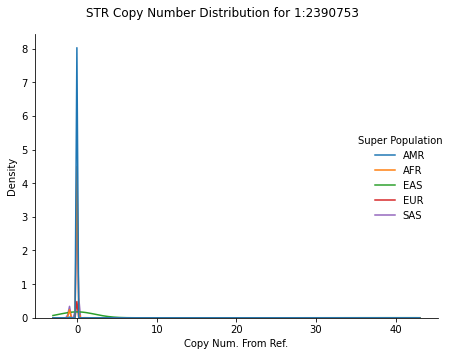

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


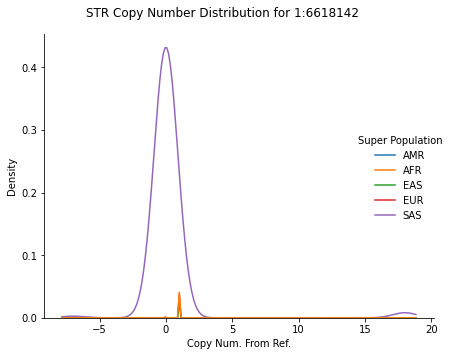

0 AMR
974 AMR
1780 AFR
1170 EAS
1266 EUR
1202 SAS


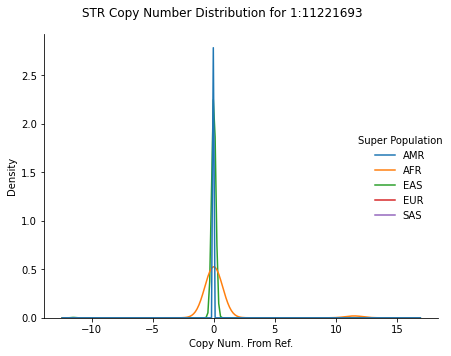

978 AMR
1780 AFR
1170 EAS
1266 EUR
1202 SAS


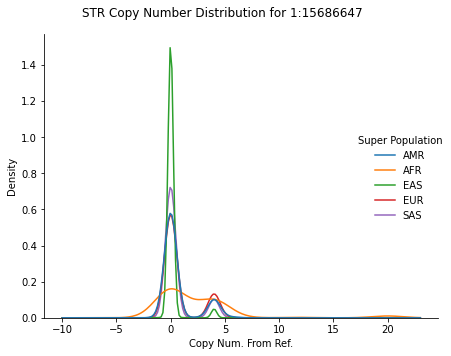

980 AMR
1154 AFR
1170 EAS
1266 EUR
1202 SAS


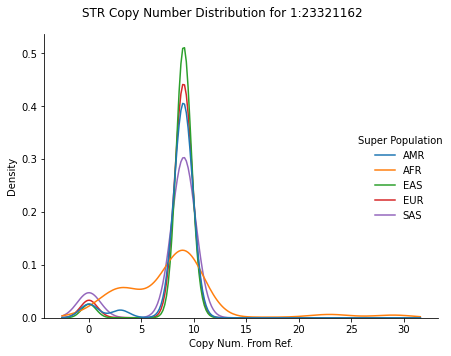

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


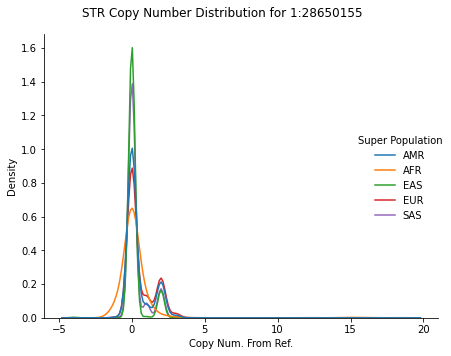

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


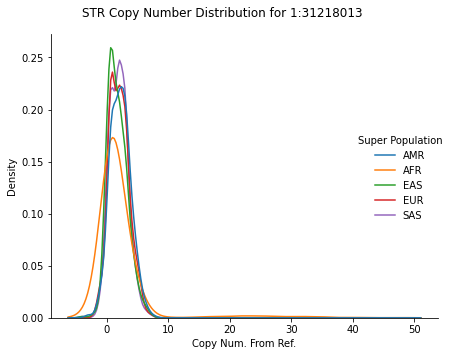

980 AMR
1782 AFR
1168 EAS
1264 EUR
1202 SAS


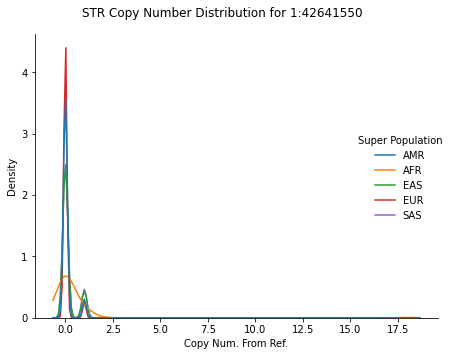

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


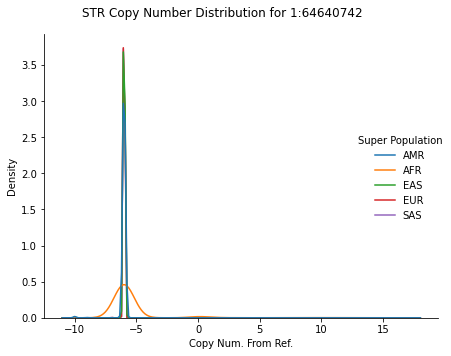

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


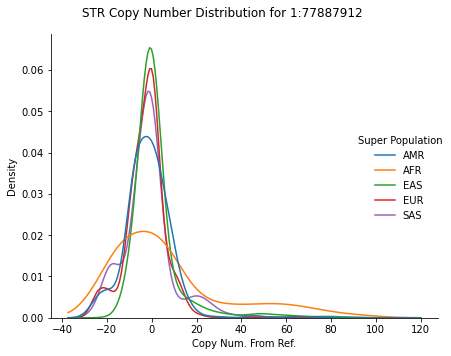

0 AMR
976 AMR
1690 AFR
1170 EAS
1264 EUR
1200 SAS


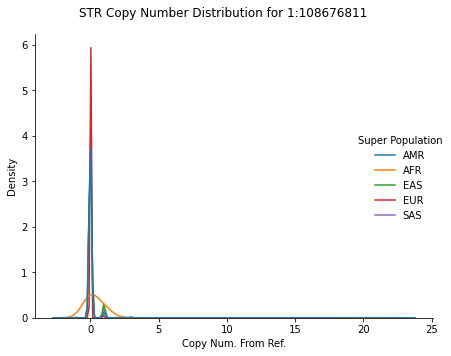

978 AMR
1738 AFR
1162 EAS
1264 EUR
1200 SAS


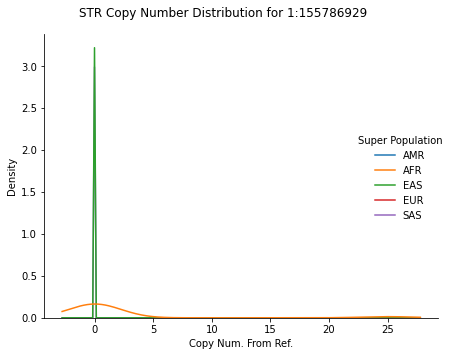

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


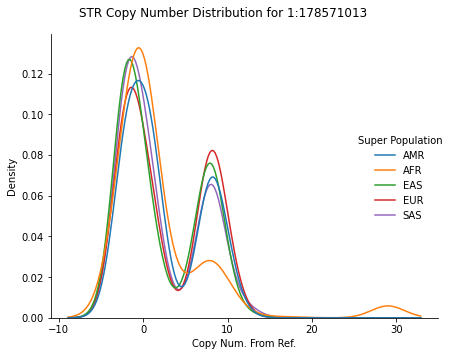

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


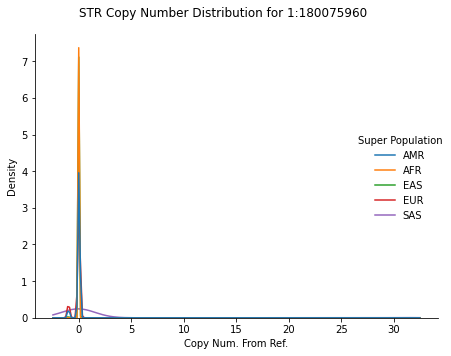

948 AMR
1382 AFR
1170 EAS
1264 EUR
1198 SAS


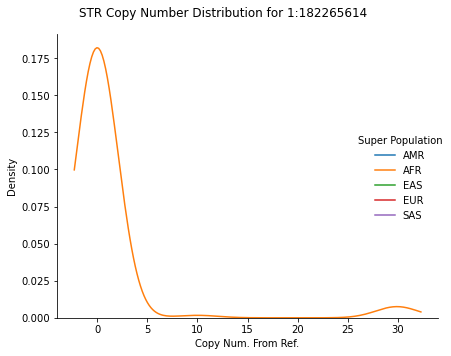

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


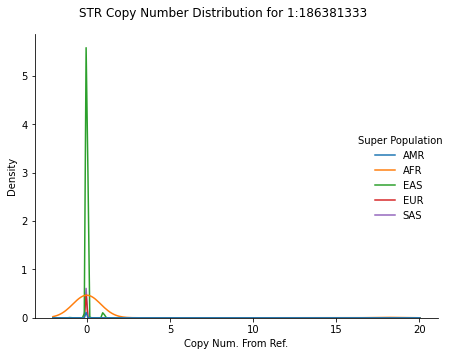

974 AMR
1758 AFR
1154 EAS
1244 EUR
1182 SAS


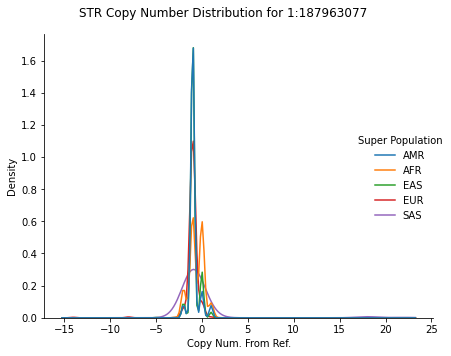

980 AMR
1006 AFR
1170 EAS
1266 EUR
1202 SAS


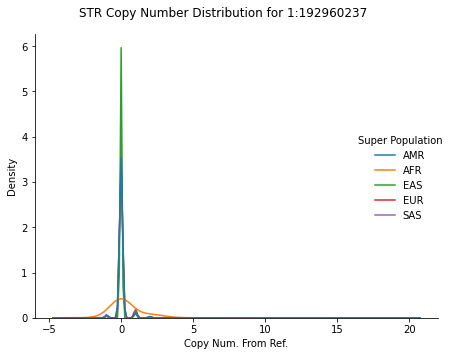

970 AMR
1666 AFR
1170 EAS
1264 EUR
1200 SAS


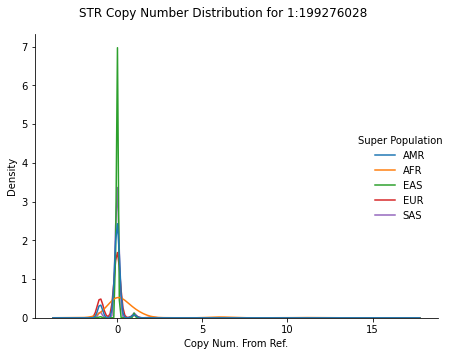

964 AMR
1782 AFR
938 EAS
1262 EUR
1148 SAS


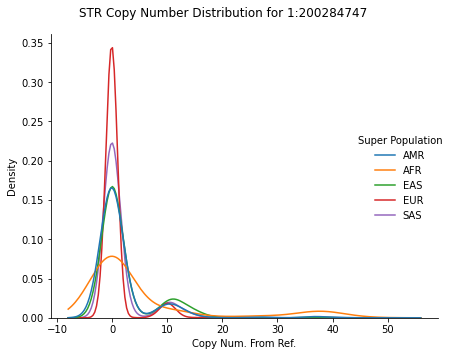

964 AMR
1750 AFR
936 EAS
1262 EUR
1146 SAS


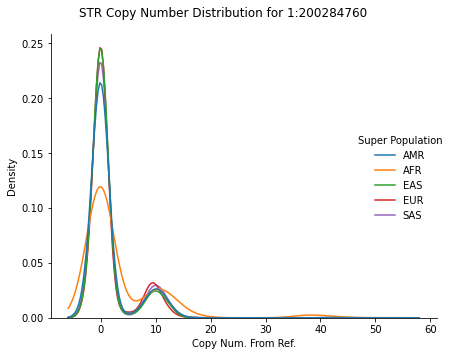

972 AMR
1702 AFR
1150 EAS
1260 EUR
1170 SAS


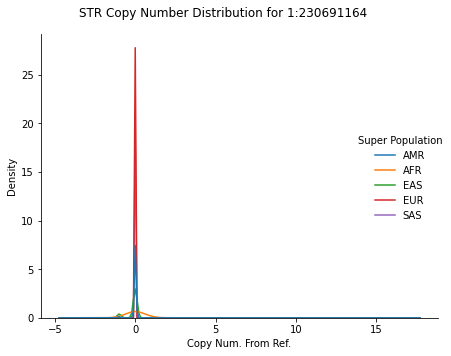

970 AMR
1770 AFR
1164 EAS
1262 EUR
1200 SAS


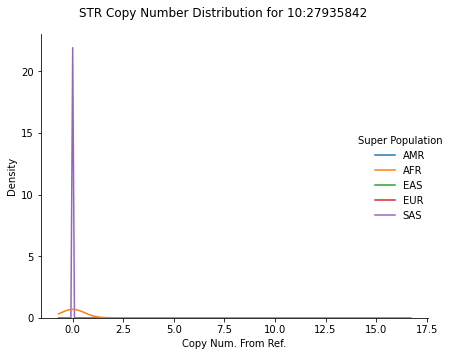

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


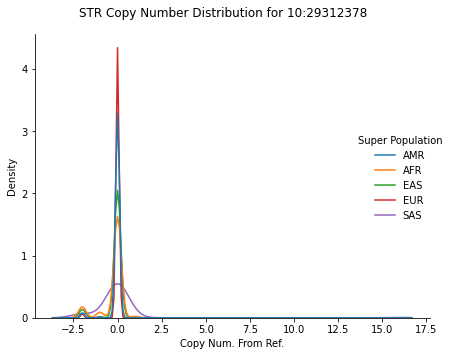

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


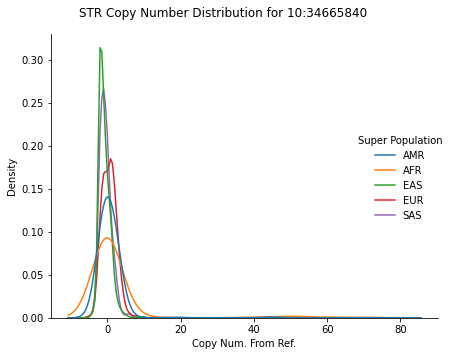

974 AMR
1392 AFR
1170 EAS
1266 EUR
1202 SAS


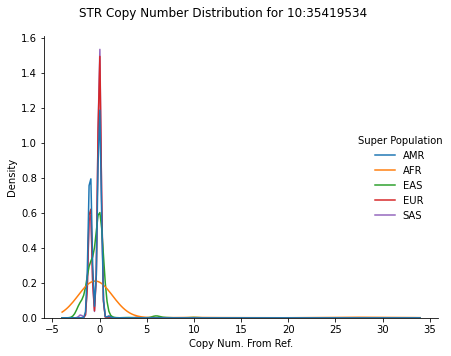

980 AMR
1724 AFR
1170 EAS
1266 EUR
1202 SAS


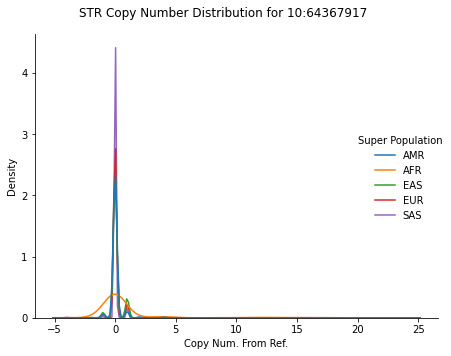

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


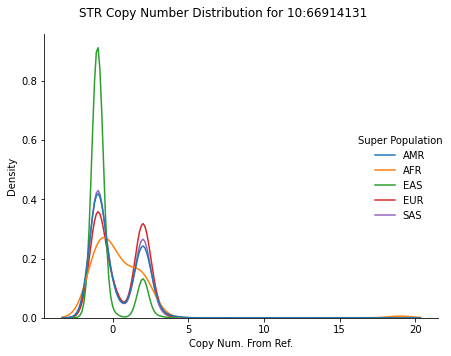

976 AMR
1756 AFR
1166 EAS
1262 EUR
1196 SAS


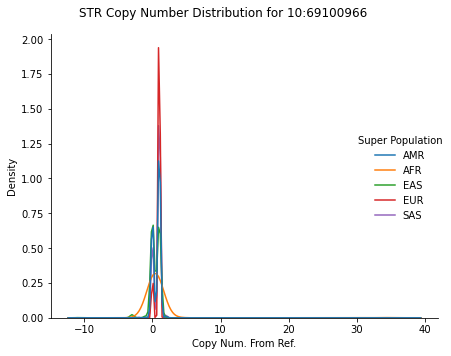

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


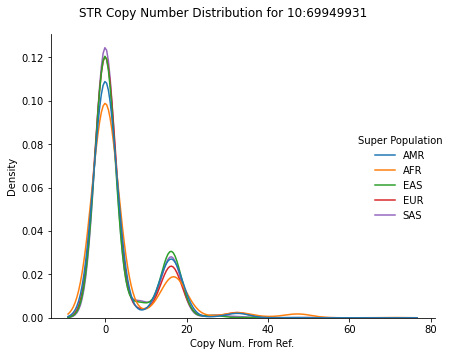

980 AMR
1786 AFR
1170 EAS
1264 EUR
1194 SAS


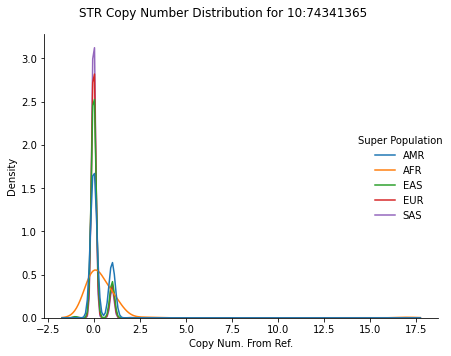

614 AMR
1464 AFR
838 EAS
1106 EUR
620 SAS


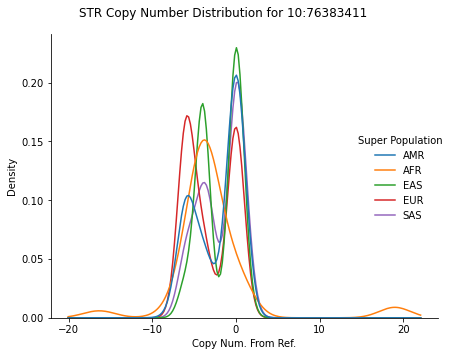

966 AMR
1674 AFR
1170 EAS
1264 EUR
1198 SAS


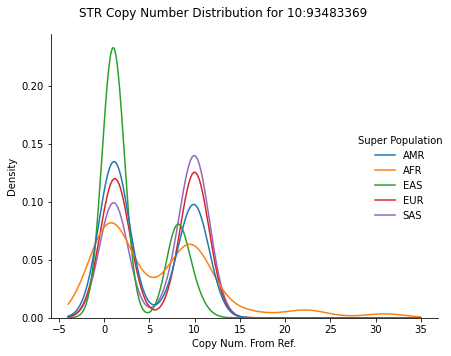

980 AMR
1780 AFR
1170 EAS
1266 EUR
1202 SAS


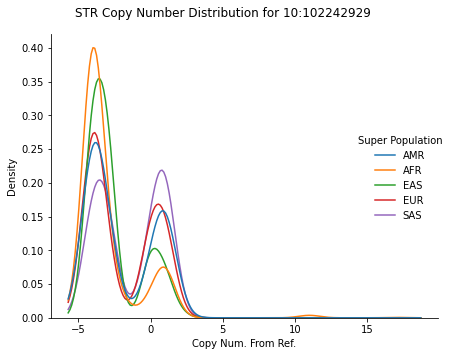

968 AMR
1718 AFR
1170 EAS
1264 EUR
1202 SAS


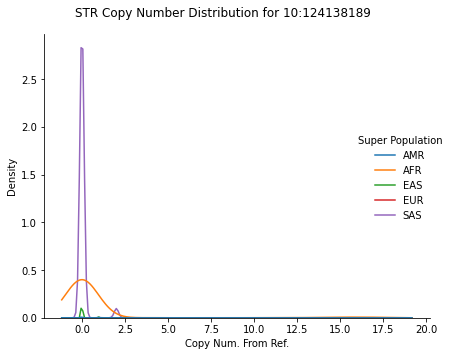

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


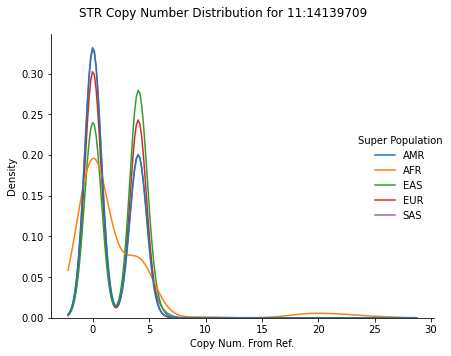

980 AMR
1770 AFR
1170 EAS
1266 EUR
1202 SAS


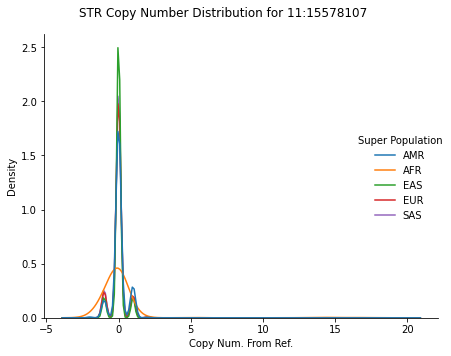

980 AMR
1776 AFR
1166 EAS
1266 EUR
1202 SAS


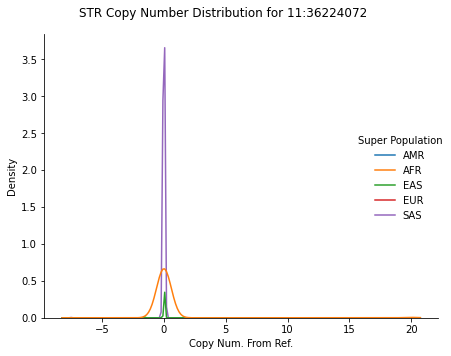

896 AMR
118 AFR
1168 EAS
1258 EUR
1188 SAS


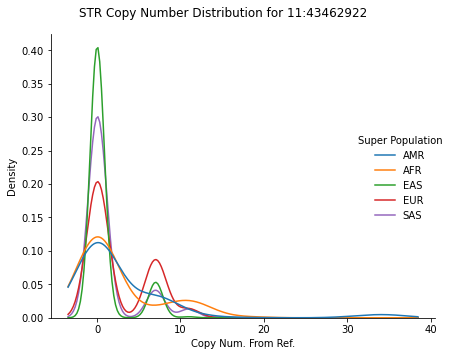

972 AMR
1786 AFR
1170 EAS
1264 EUR
1186 SAS


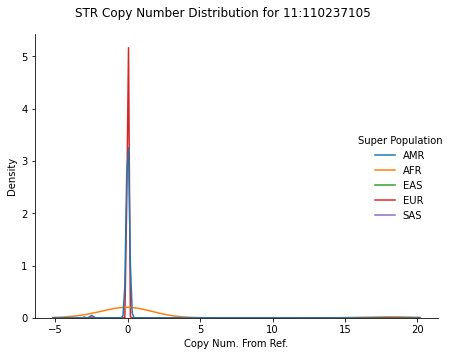

980 AMR
1770 AFR
1170 EAS
1266 EUR
1202 SAS


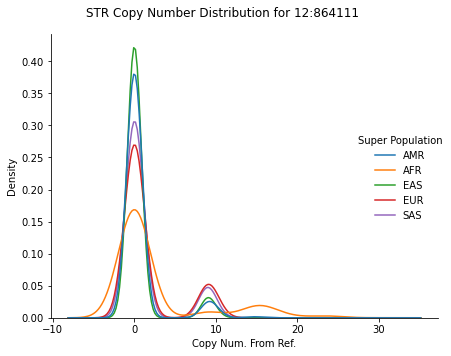

972 AMR
1764 AFR
1168 EAS
1266 EUR
1196 SAS


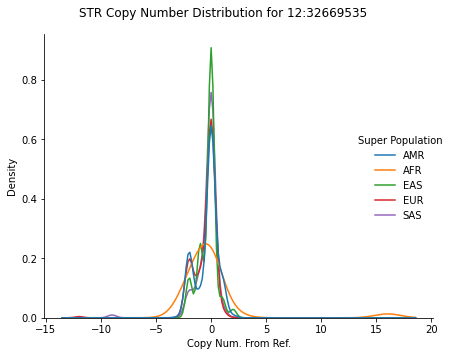

872 AMR
1030 AFR
1130 EAS
1172 EUR
1104 SAS


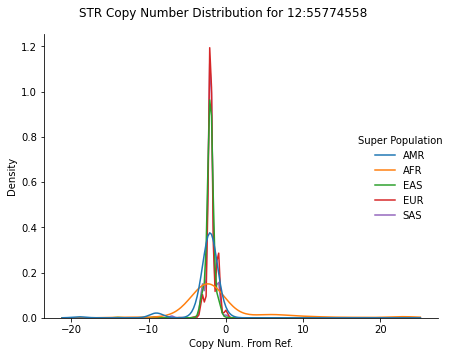

956 AMR
1632 AFR
1166 EAS
1264 EUR
1194 SAS


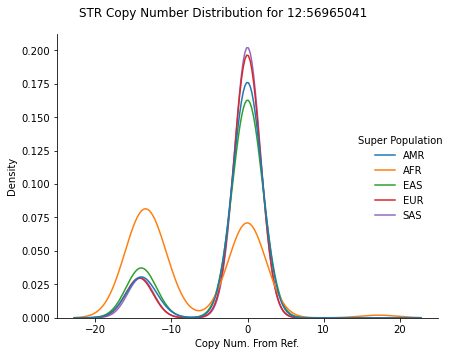

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


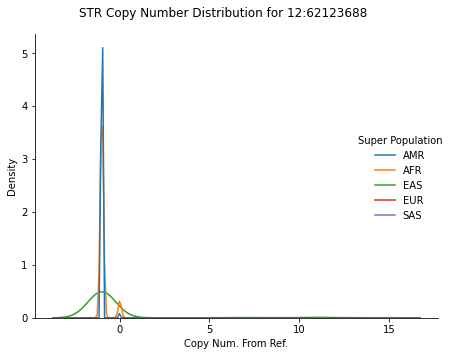

870 AMR
518 AFR
502 EAS
1198 EUR
1162 SAS


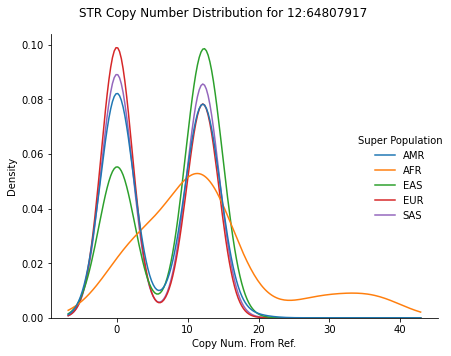

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


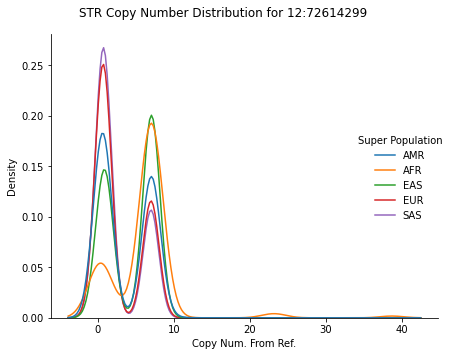

954 AMR
1574 AFR
1166 EAS
1248 EUR
1190 SAS


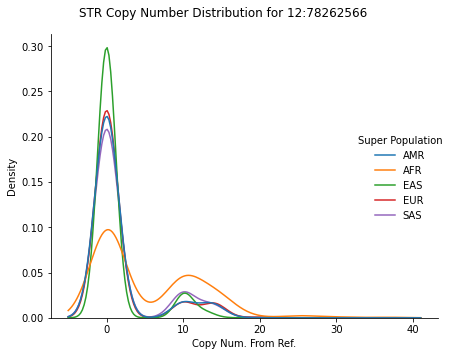

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


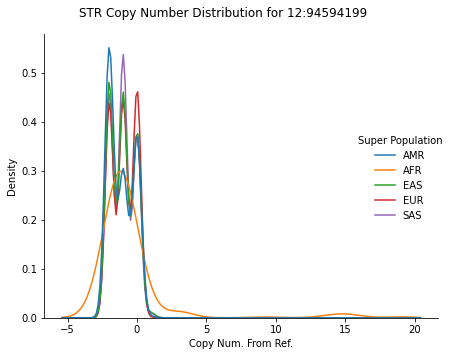

980 AMR
1780 AFR
1170 EAS
1266 EUR
1200 SAS


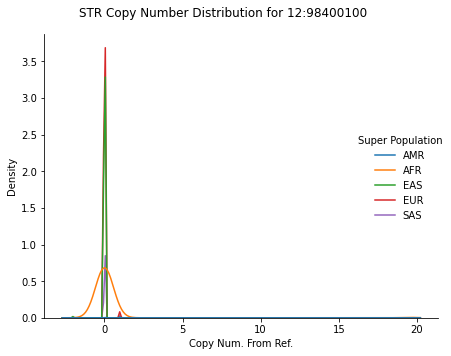

956 AMR
1688 AFR
1170 EAS
1266 EUR
1202 SAS


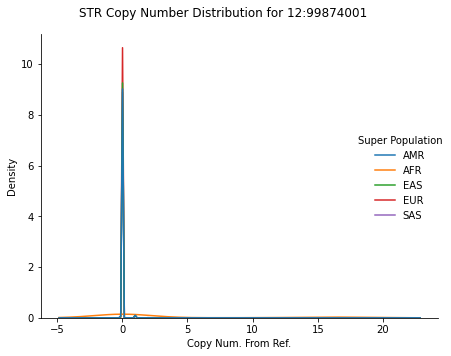

970 AMR
1530 AFR
1154 EAS
1248 EUR
1164 SAS


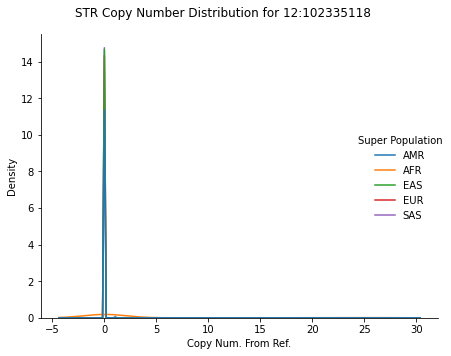

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


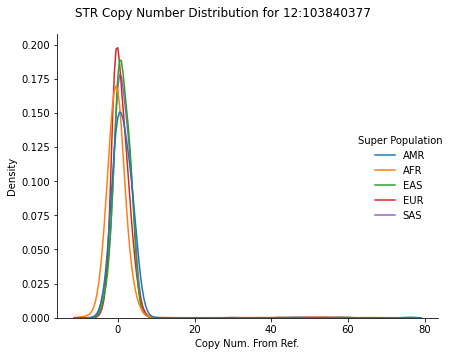

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


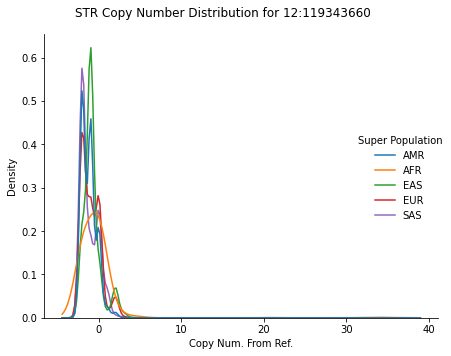

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


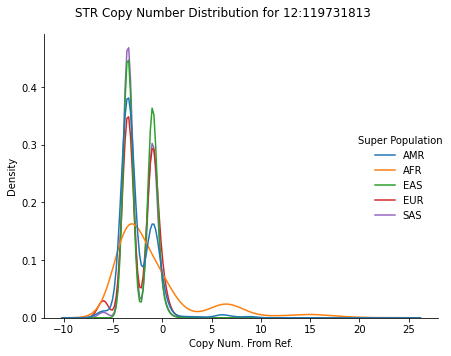

912 AMR
936 AFR
1168 EAS
1200 EUR
1174 SAS


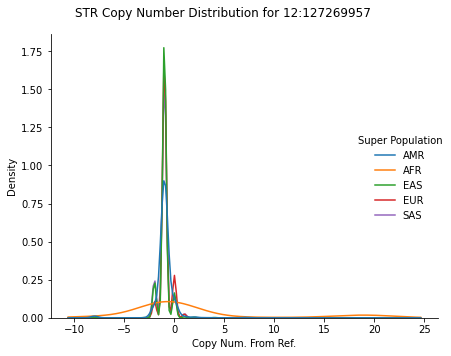

976 AMR
1778 AFR
1170 EAS
1266 EUR
1202 SAS


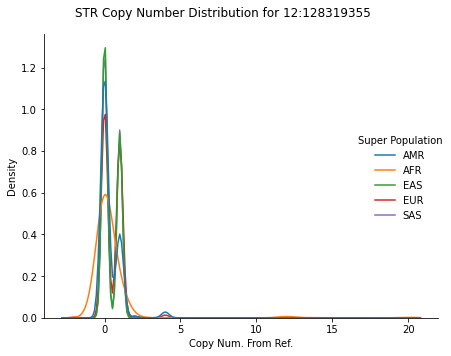

974 AMR
1664 AFR
976 EAS
1262 EUR
856 SAS


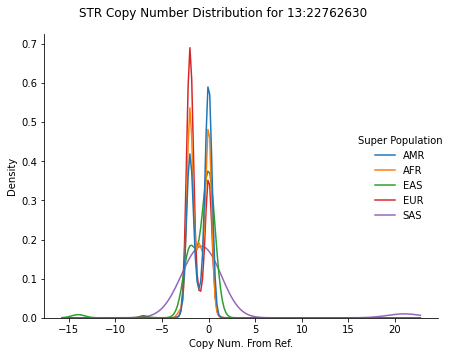

974 AMR
1760 AFR
1156 EAS
1252 EUR
1194 SAS


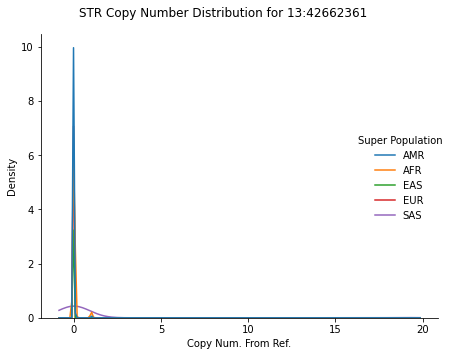

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


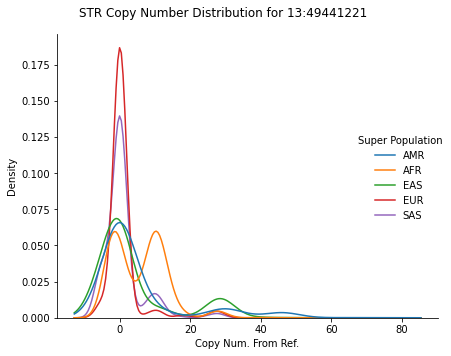

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


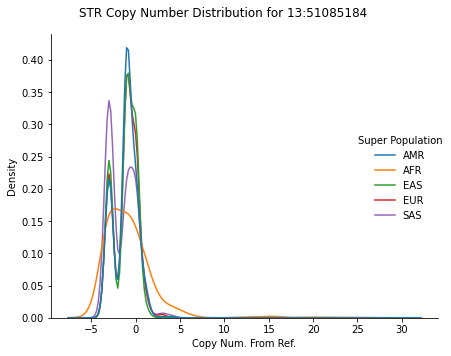

972 AMR
1718 AFR
1168 EAS
1266 EUR
1202 SAS


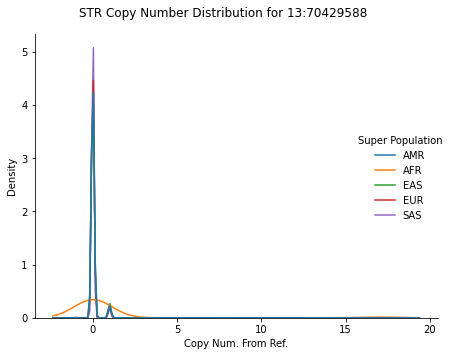

980 AMR
1774 AFR
1170 EAS
1266 EUR
1202 SAS


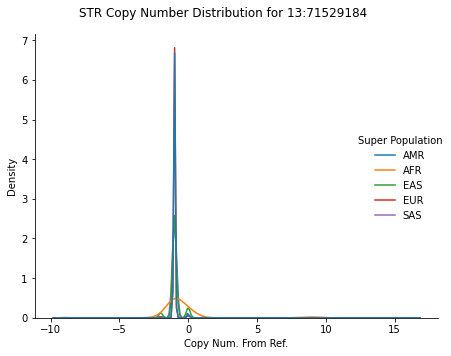

980 AMR
1576 AFR
1170 EAS
1266 EUR
1202 SAS


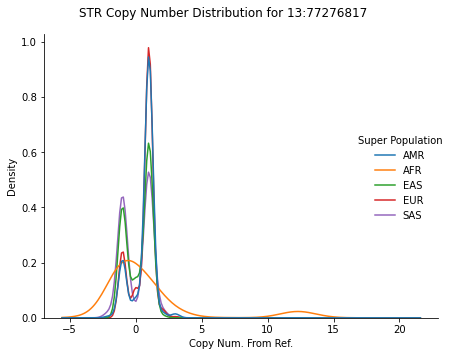

974 AMR
1144 AFR
1166 EAS
1262 EUR
1198 SAS


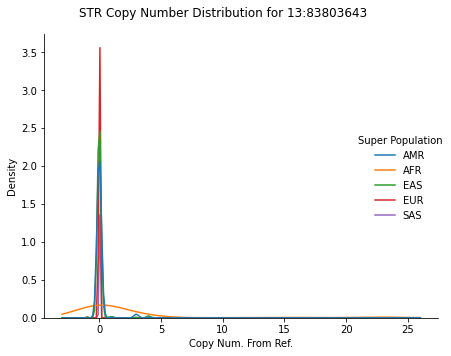

886 AMR
1606 AFR
1120 EAS
1144 EUR
1114 SAS


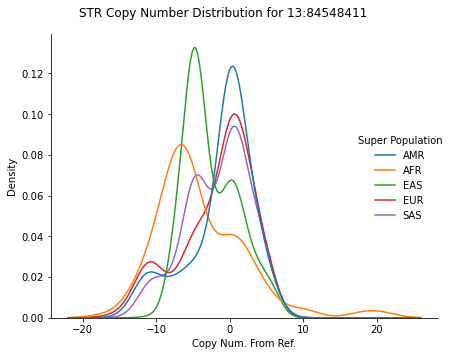

976 AMR
1764 AFR
1170 EAS
1266 EUR
1202 SAS


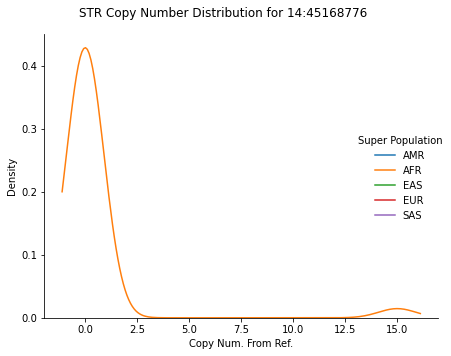

976 AMR
1732 AFR
1146 EAS
1264 EUR
1194 SAS


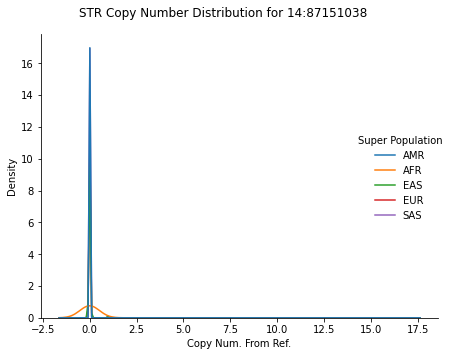

976 AMR
1784 AFR
1170 EAS
1264 EUR
1202 SAS


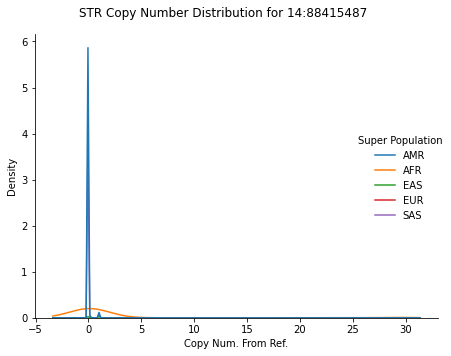

980 AMR
494 AFR
1170 EAS
1264 EUR
1202 SAS


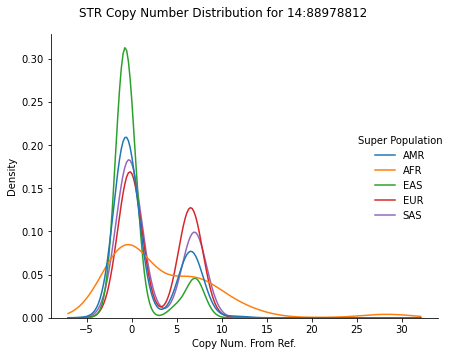

980 AMR
1764 AFR
1166 EAS
1264 EUR
1202 SAS


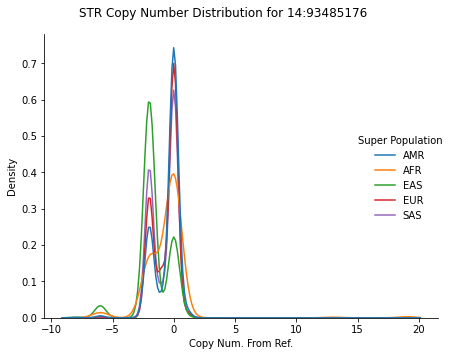

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


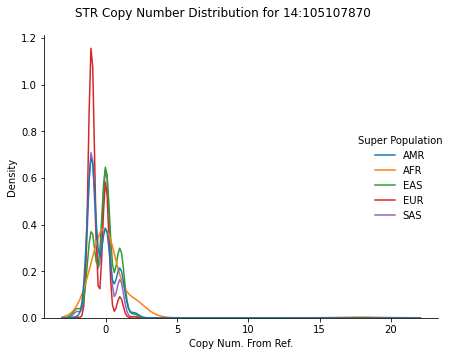

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


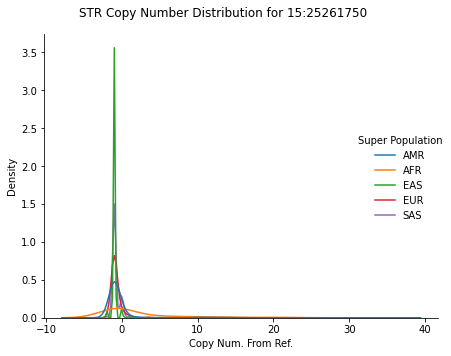

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


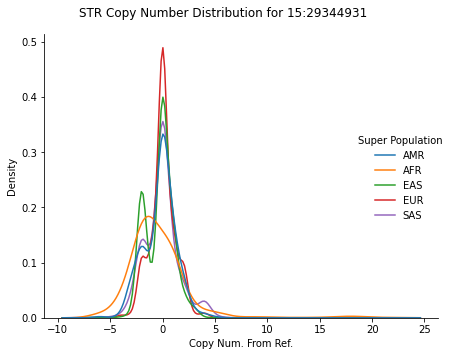

978 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


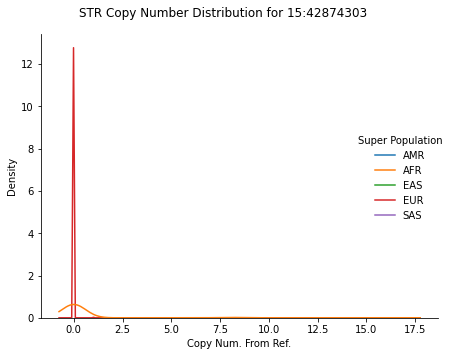

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


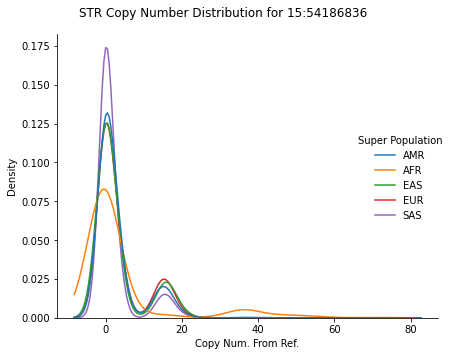

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


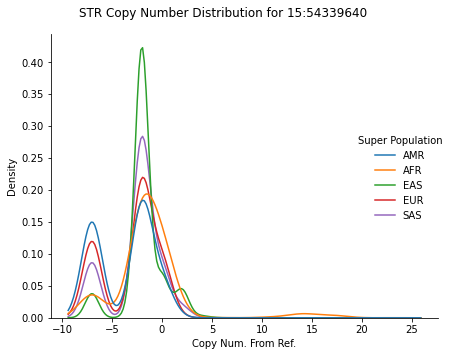

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


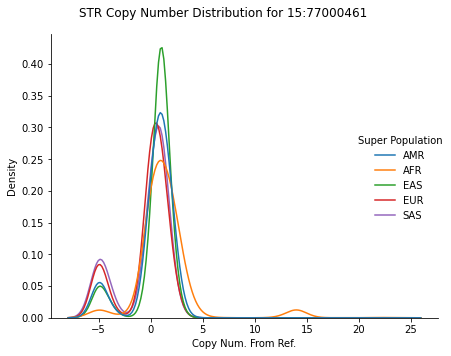

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


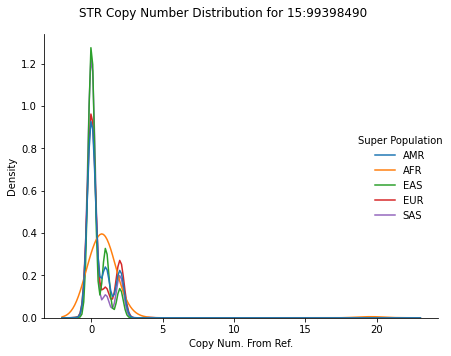

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


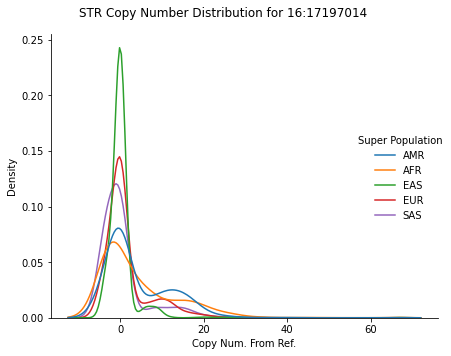

948 AMR
1042 AFR
1104 EAS
1236 EUR
1154 SAS


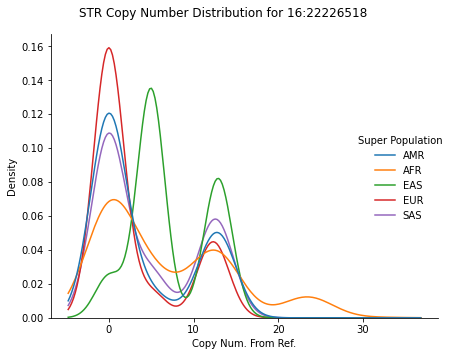

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


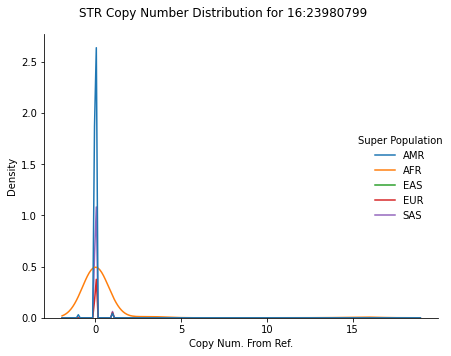

966 AMR
1278 AFR
1158 EAS
1252 EUR
1188 SAS


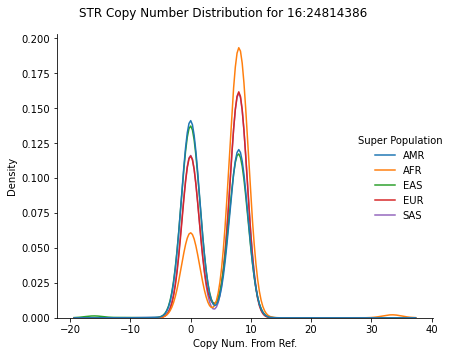

958 AMR
1718 AFR
1164 EAS
1200 EUR
1156 SAS


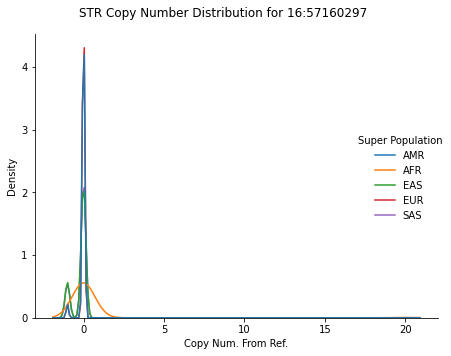

980 AMR
1780 AFR
1170 EAS
1266 EUR
1202 SAS


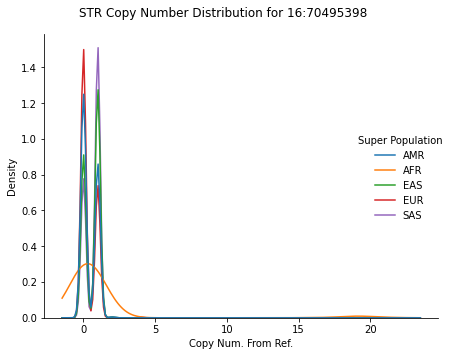

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


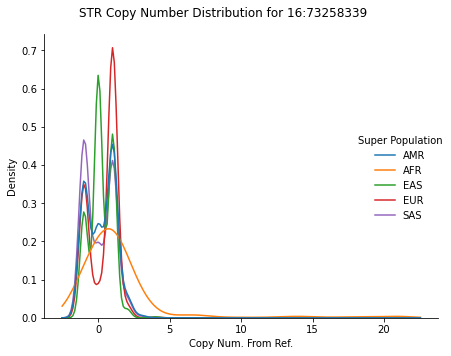

974 AMR
1748 AFR
1168 EAS
1264 EUR
1198 SAS


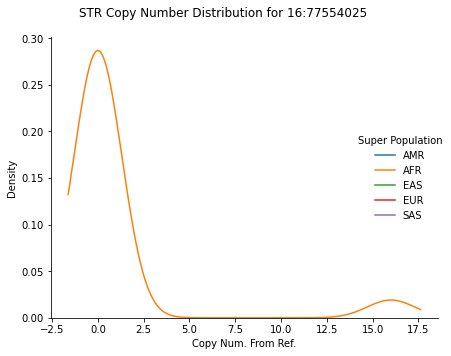

972 AMR
1690 AFR
1152 EAS
1234 EUR
1174 SAS


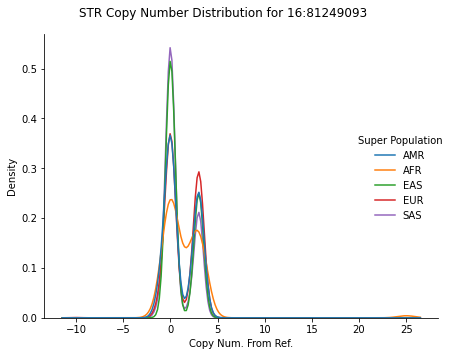

960 AMR
1466 AFR
1170 EAS
1266 EUR
1196 SAS


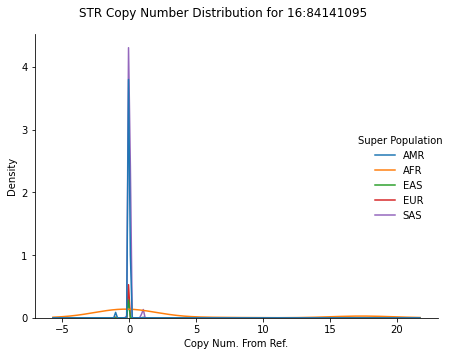

974 AMR
1730 AFR
1166 EAS
1266 EUR
1190 SAS


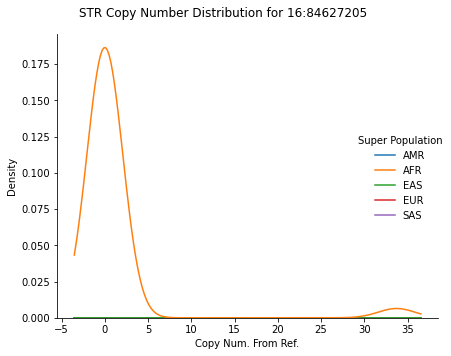

980 AMR
1770 AFR
1170 EAS
1266 EUR
1202 SAS


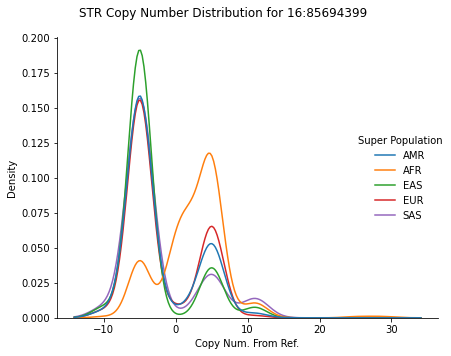

944 AMR
1484 AFR
1160 EAS
1250 EUR
1200 SAS


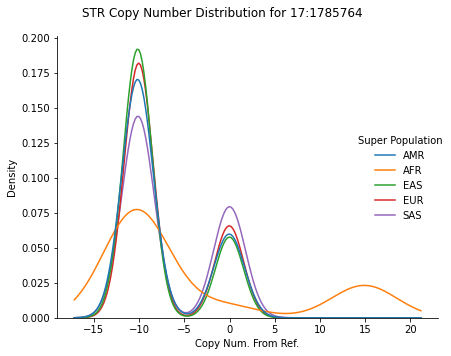

966 AMR
1602 AFR
1144 EAS
1252 EUR
1170 SAS


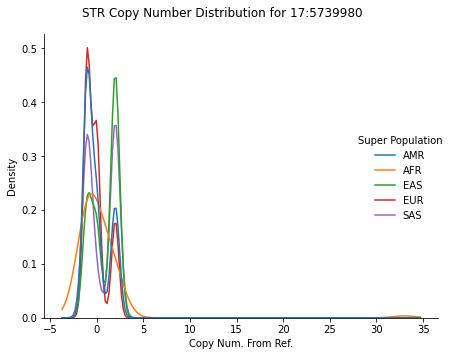

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


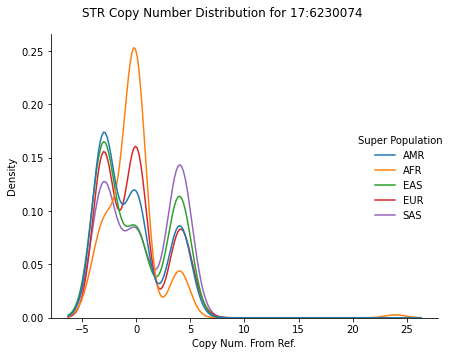

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


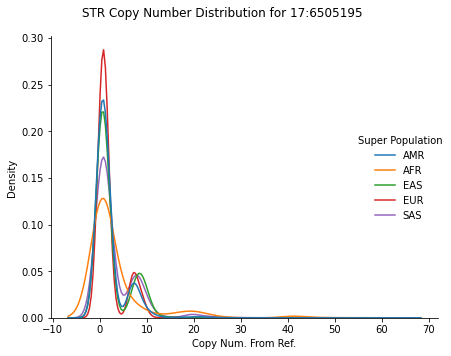

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


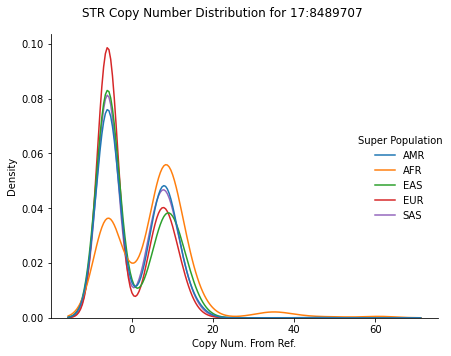

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


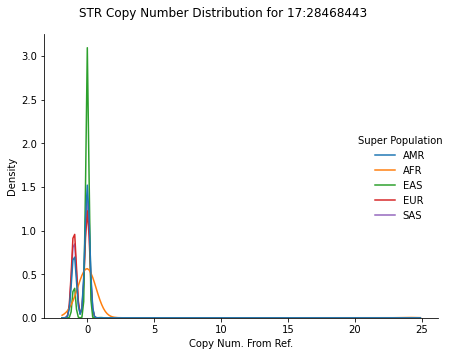

608 AMR
114 AFR
0 EAS
980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


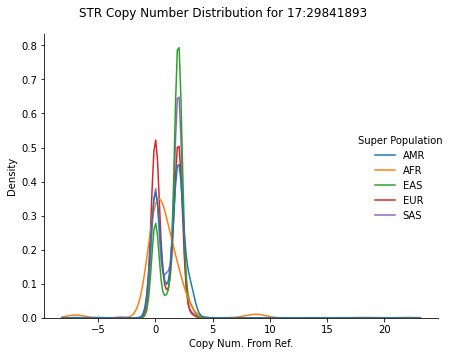

562 AMR
1452 AFR
582 EAS
722 EUR
1012 SAS


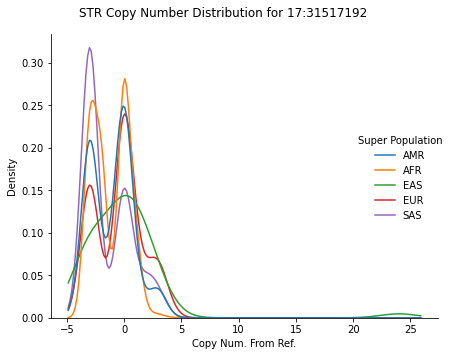

918 AMR
928 AFR
1118 EAS
1172 EUR
1152 SAS


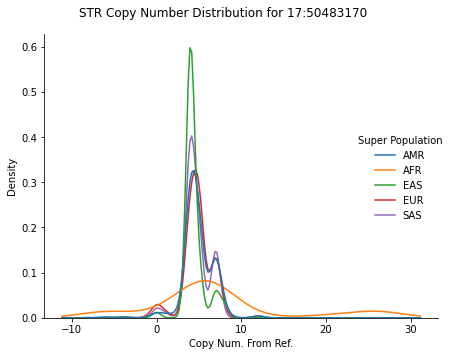

976 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


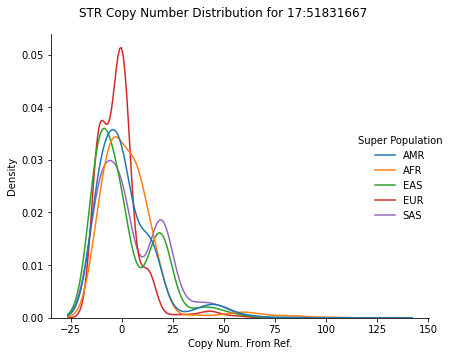

968 AMR
1324 AFR
1170 EAS
1266 EUR
1200 SAS


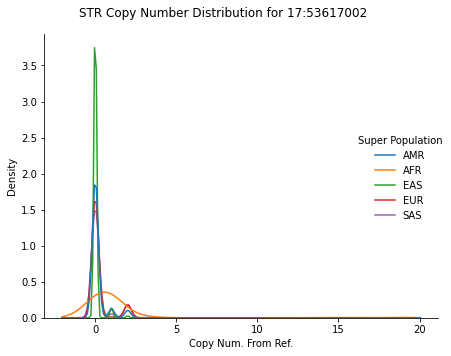

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


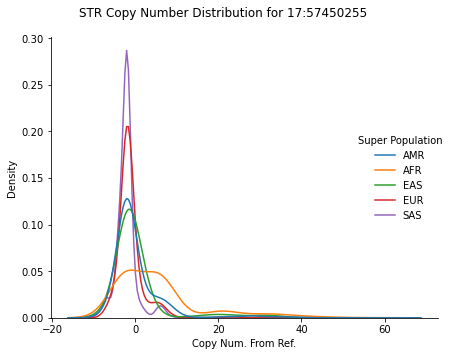

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


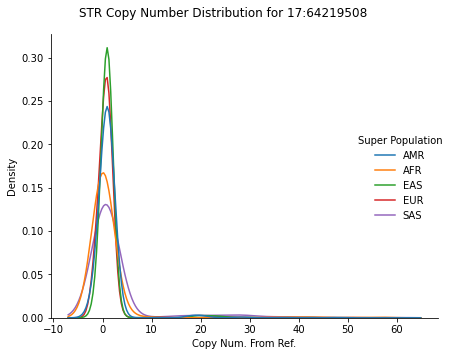

962 AMR
1604 AFR
1170 EAS
1266 EUR
1202 SAS


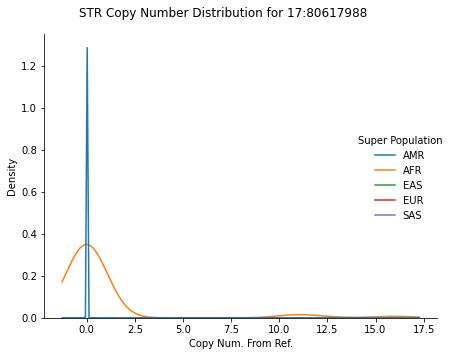

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


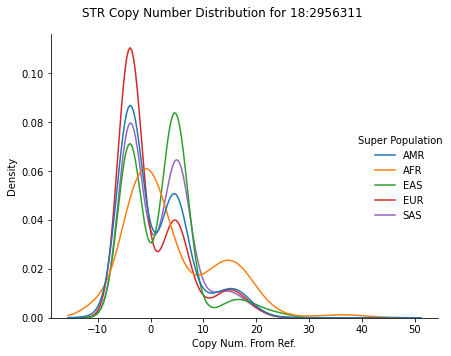

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


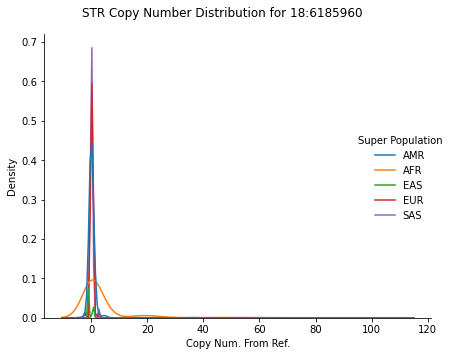

934 AMR
734 AFR
1166 EAS
1264 EUR
1200 SAS


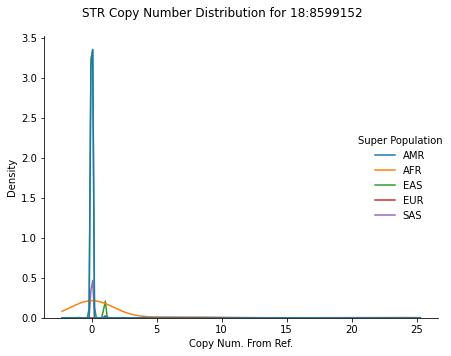

980 AMR
1730 AFR
1170 EAS
1266 EUR
1202 SAS


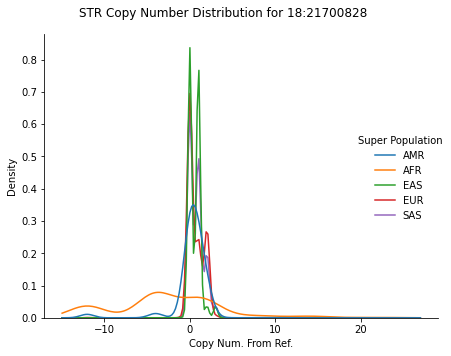

612 AMR
550 AFR
330 EAS
1090 EUR
940 SAS


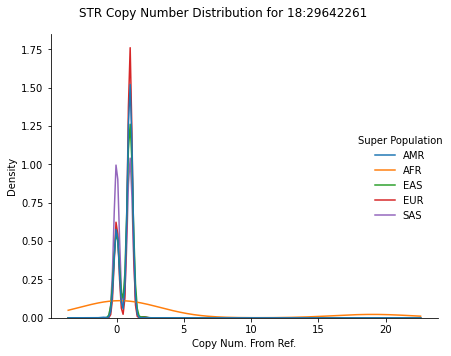

980 AMR
1786 AFR
1170 EAS
1262 EUR
1202 SAS


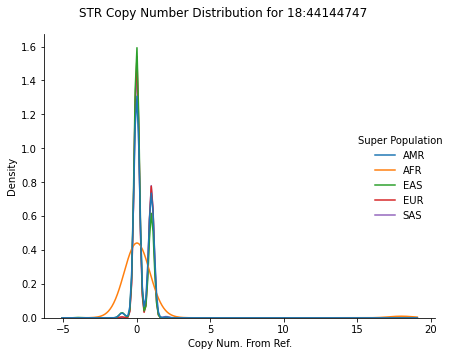

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


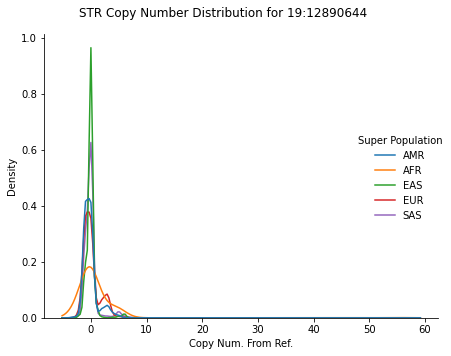

980 AMR
1770 AFR
1164 EAS
1264 EUR
1198 SAS


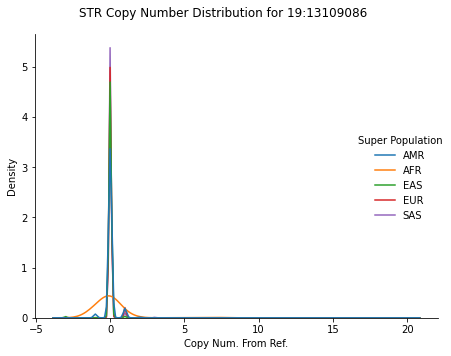

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


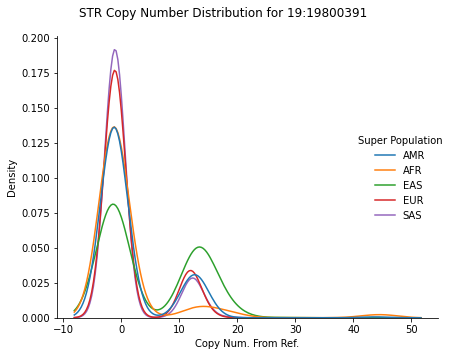

976 AMR
1768 AFR
1170 EAS
1266 EUR
1202 SAS


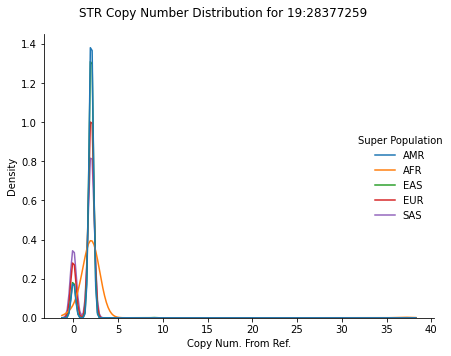

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


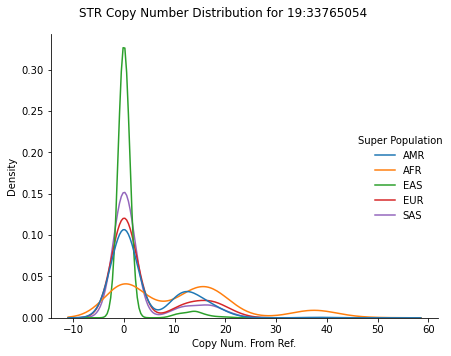

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


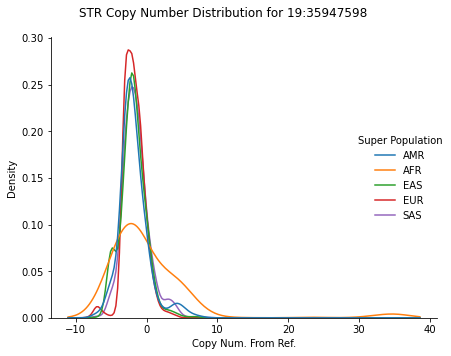

980 AMR
1638 AFR
1170 EAS
1264 EUR
1202 SAS


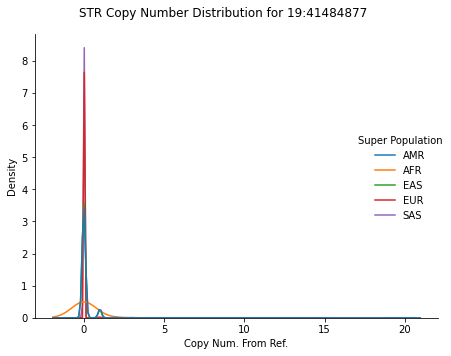

960 AMR
1750 AFR
1142 EAS
1248 EUR
1178 SAS


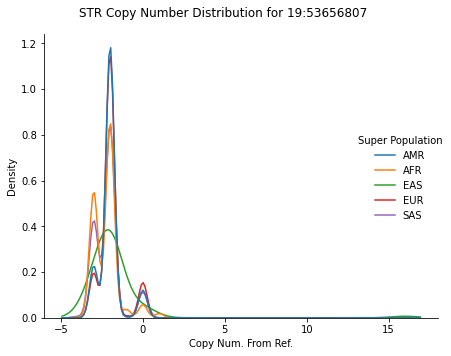

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


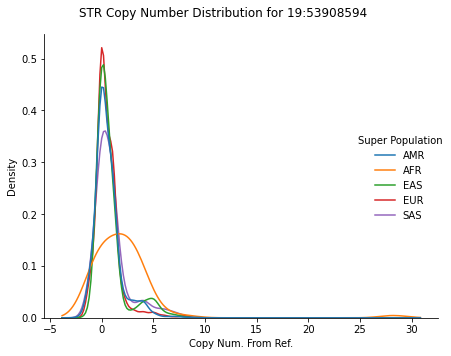

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


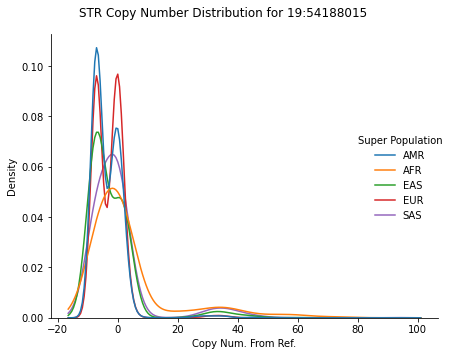

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


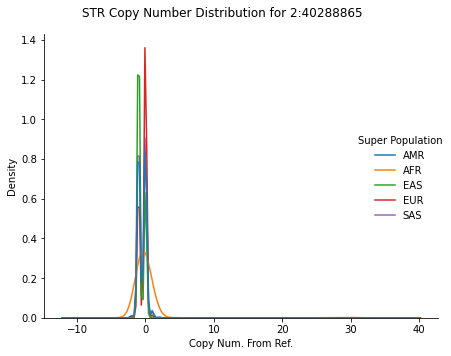

968 AMR
1740 AFR
1162 EAS
1256 EUR
1192 SAS


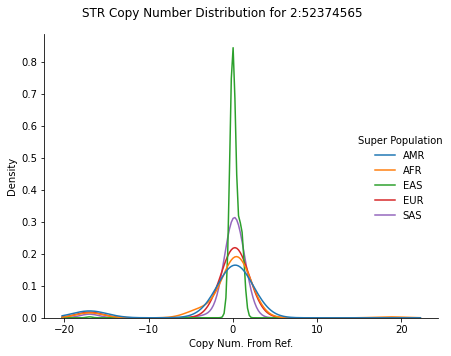

980 AMR
1778 AFR
1170 EAS
1266 EUR
1202 SAS


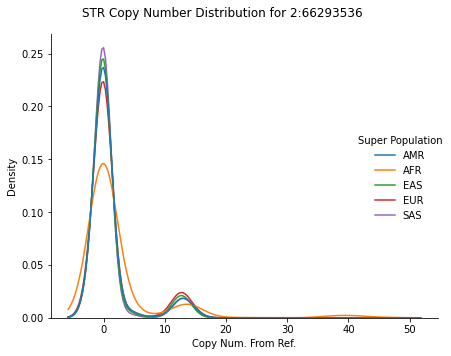

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


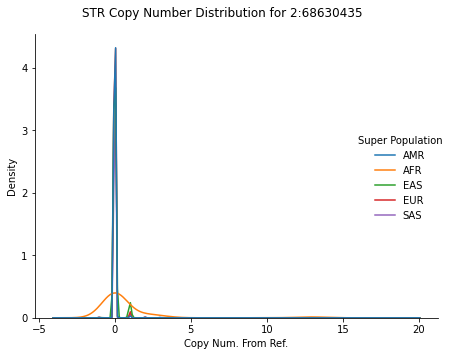

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


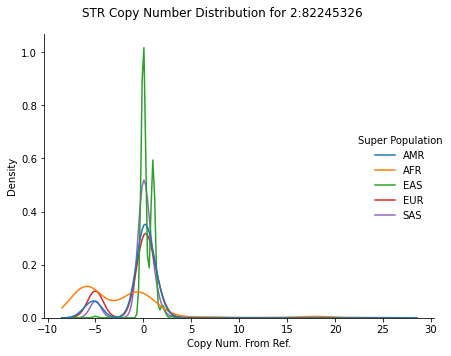

974 AMR
1770 AFR
1168 EAS
1250 EUR
1198 SAS


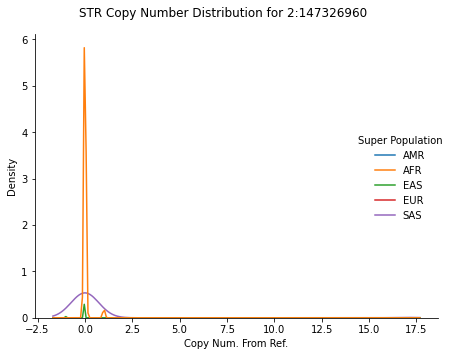

972 AMR
1704 AFR
1170 EAS
1266 EUR
1202 SAS


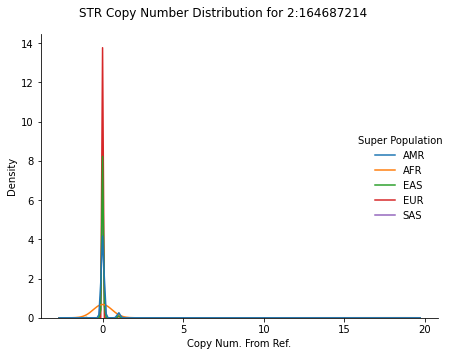

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


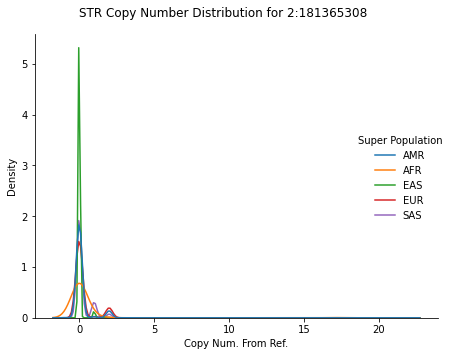

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


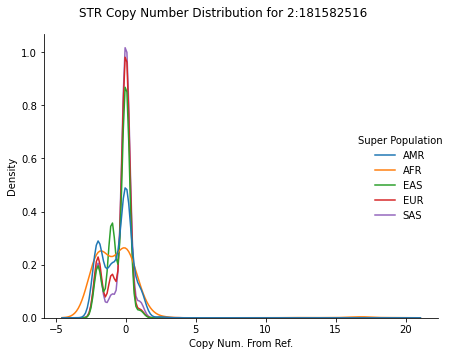

972 AMR
1782 AFR
1166 EAS
1262 EUR
1196 SAS


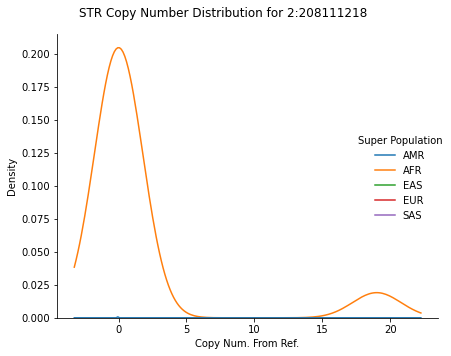

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


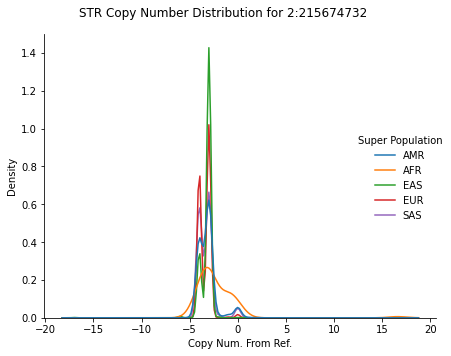

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


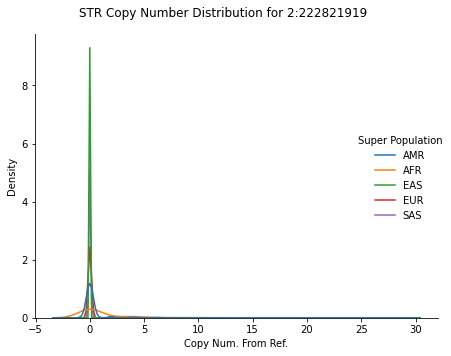

960 AMR
1658 AFR
1138 EAS
1264 EUR
1192 SAS


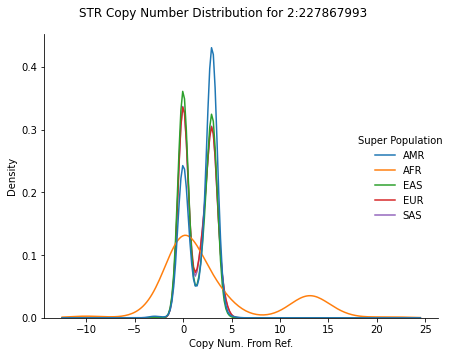

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


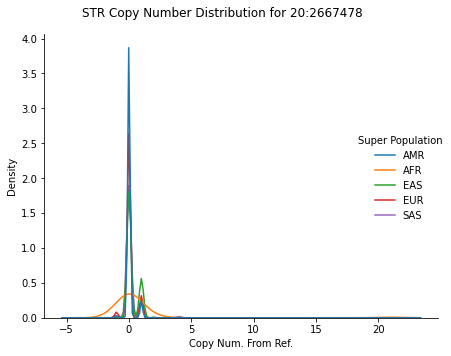

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


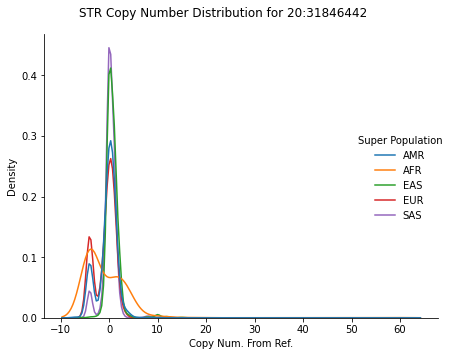

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


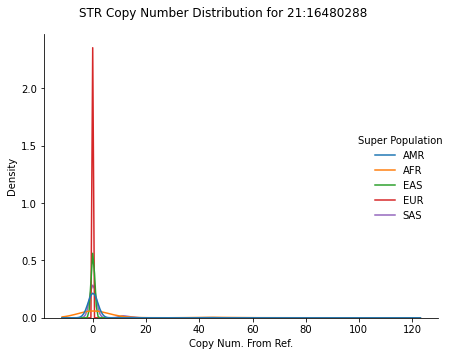

980 AMR
1462 AFR
1170 EAS
1266 EUR
1202 SAS


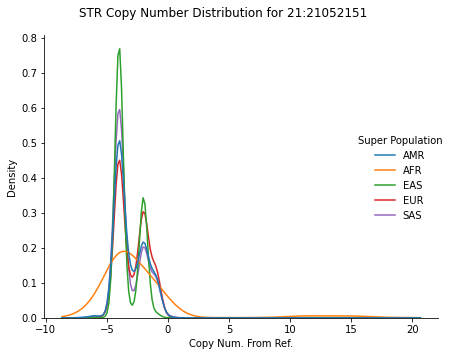

950 AMR
1674 AFR
1132 EAS
1224 EUR
1146 SAS


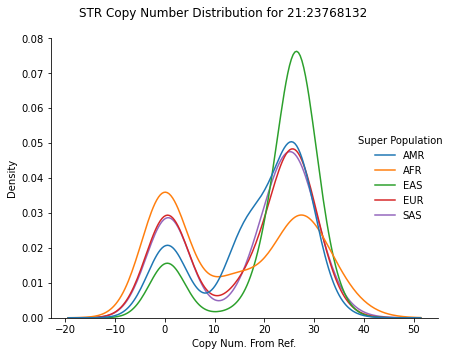

954 AMR
1722 AFR
1150 EAS
1248 EUR
1176 SAS


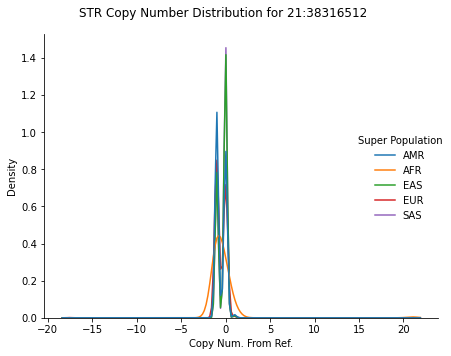

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


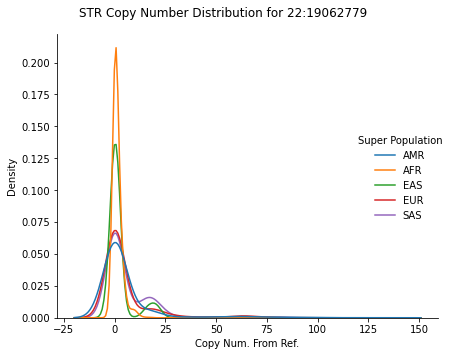

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


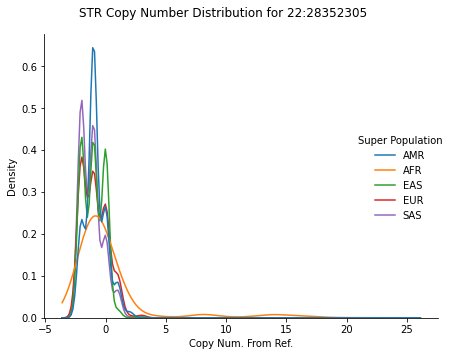

916 AMR
1338 AFR
1114 EAS
1202 EUR
1144 SAS


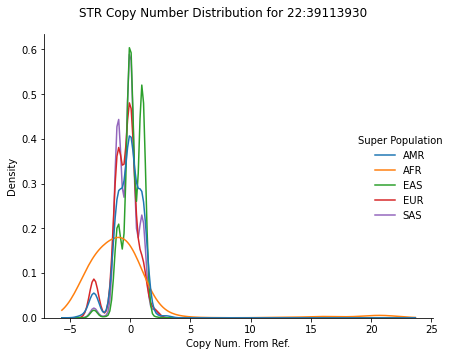

972 AMR
1666 AFR
1126 EAS
1260 EUR
1190 SAS


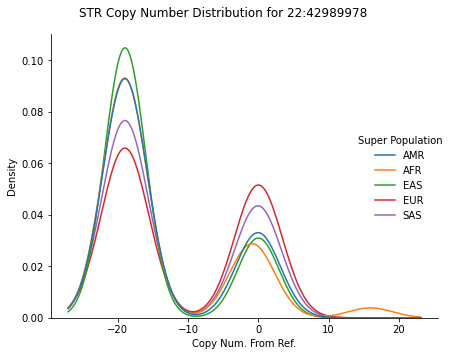

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


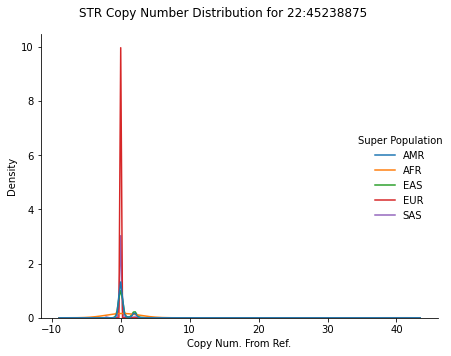

980 AMR
1764 AFR
1170 EAS
1264 EUR
1190 SAS


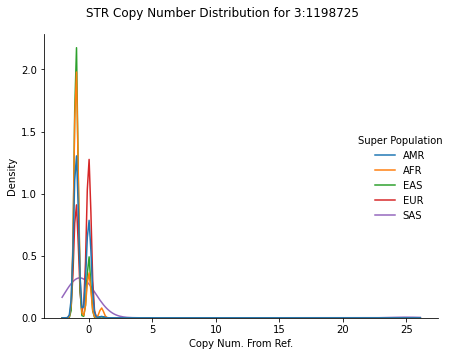

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


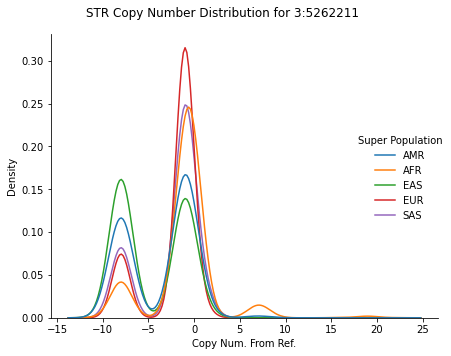

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


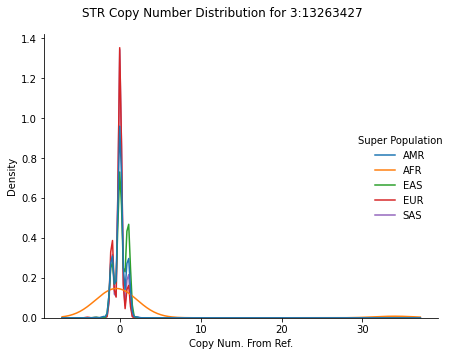

978 AMR
1782 AFR
1168 EAS
1266 EUR
1200 SAS


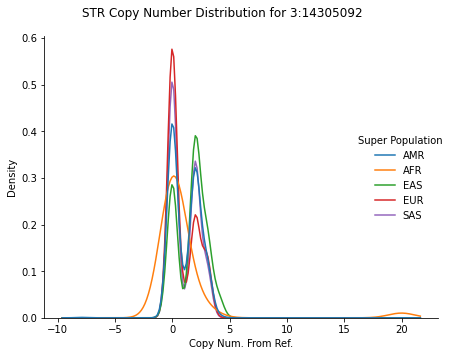

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


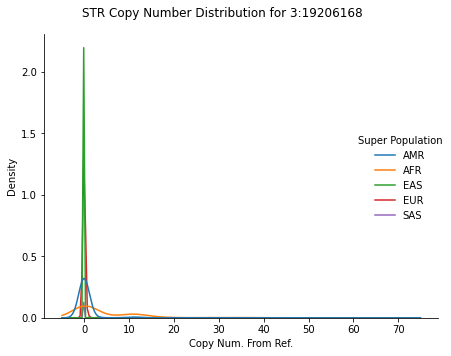

980 AMR
1782 AFR
1168 EAS
1266 EUR
1202 SAS


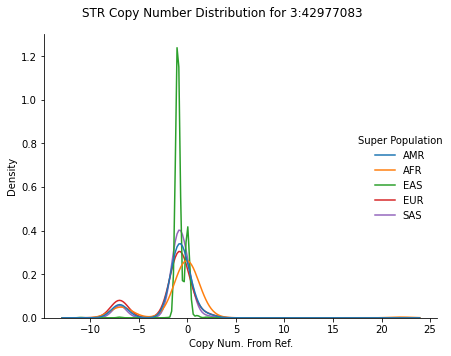

978 AMR
1784 AFR
1170 EAS
1266 EUR
1198 SAS


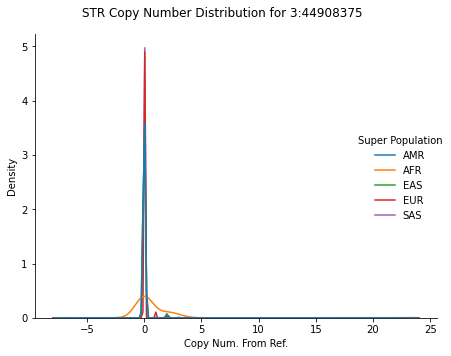

0 AMR
980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


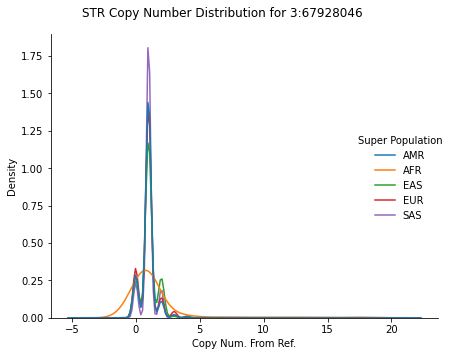

980 AMR
1764 AFR
1170 EAS
1266 EUR
1202 SAS


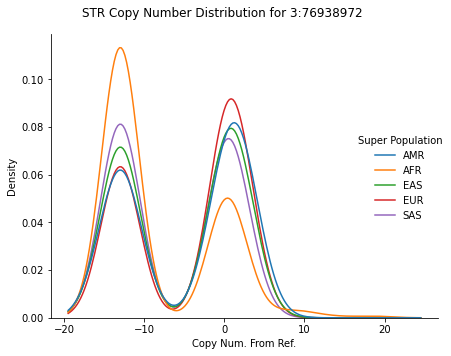

980 AMR
1762 AFR
1170 EAS
1266 EUR
1202 SAS


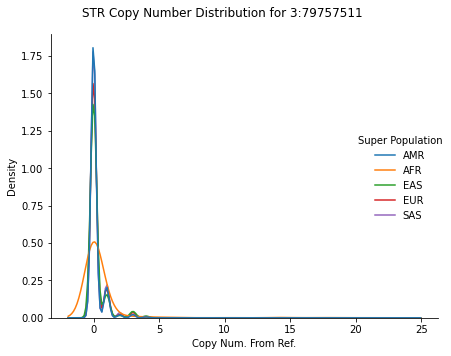

980 AMR
1786 AFR
1168 EAS
1266 EUR
1202 SAS


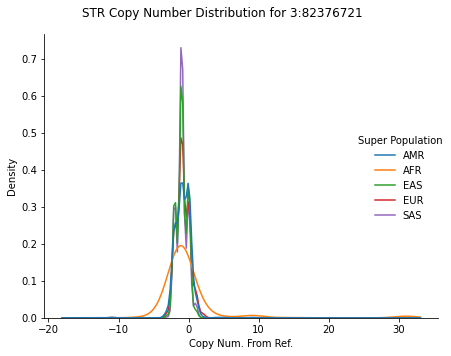

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


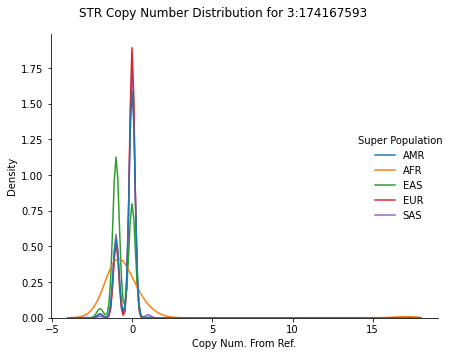

978 AMR
1782 AFR
1170 EAS
1266 EUR
1192 SAS


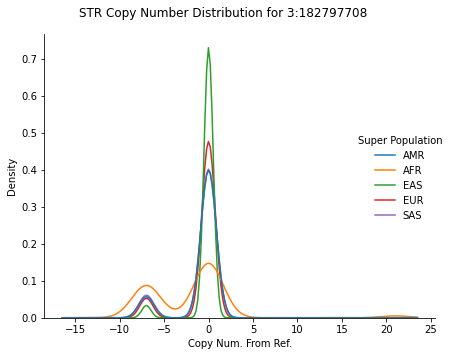

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


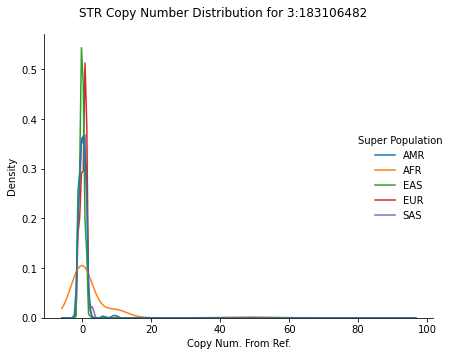

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


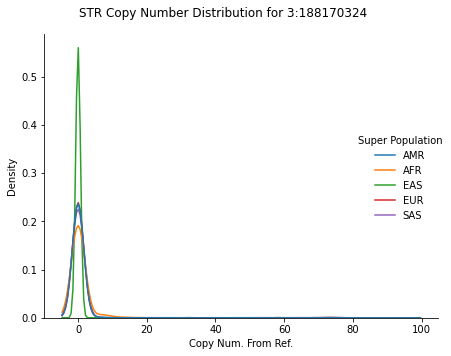

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


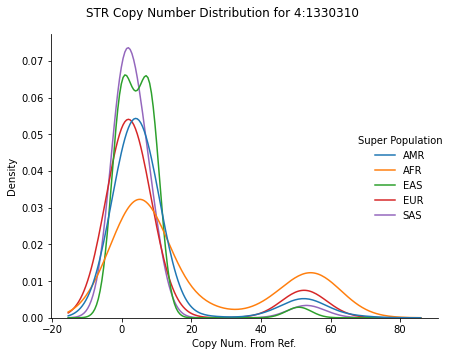

980 AMR
1782 AFR
1166 EAS
1266 EUR
1202 SAS


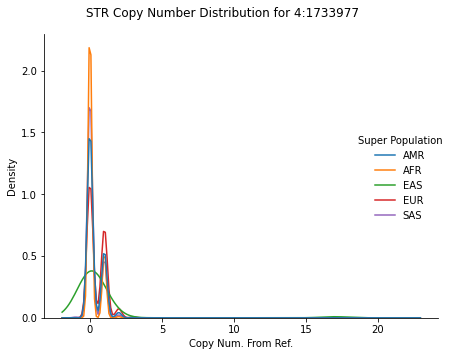

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


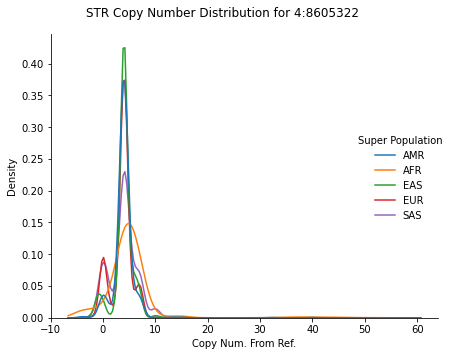

964 AMR
1504 AFR
1164 EAS
1242 EUR
1166 SAS


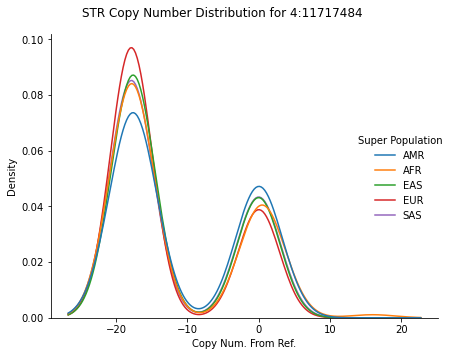

980 AMR
1720 AFR
1170 EAS
1266 EUR
1202 SAS


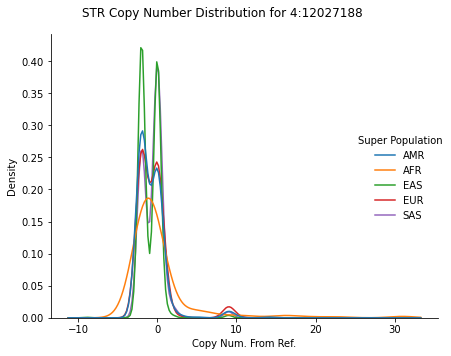

716 AMR
1780 AFR
980 EAS
540 EUR
1200 SAS


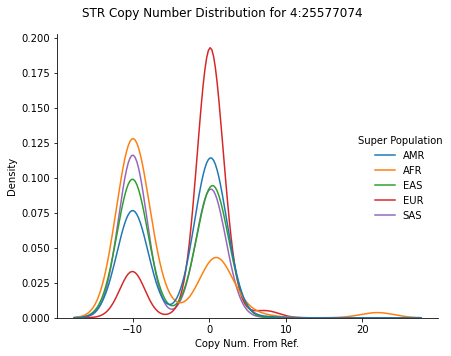

980 AMR
1776 AFR
1170 EAS
1266 EUR
1202 SAS


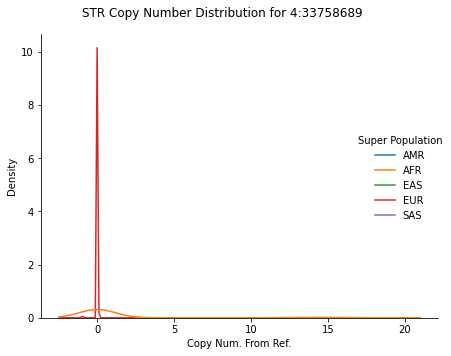

968 AMR
1652 AFR
1170 EAS
1264 EUR
1200 SAS


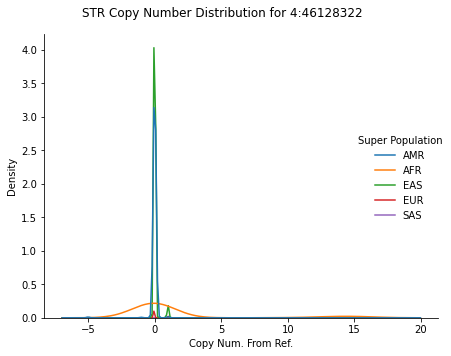

976 AMR
1710 AFR
1170 EAS
1264 EUR
1200 SAS


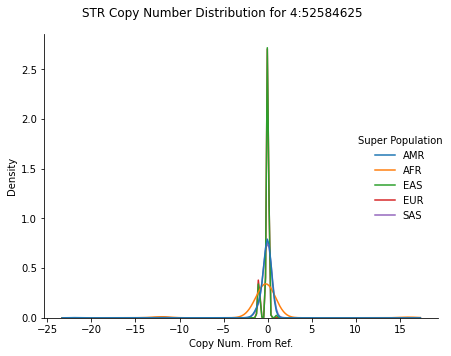

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


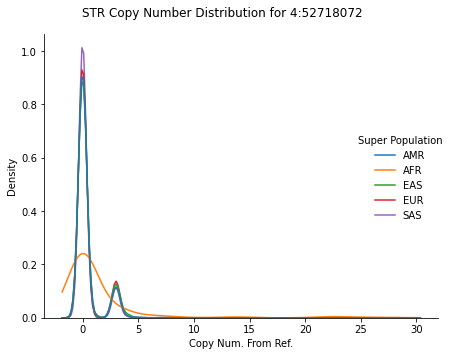

968 AMR
818 AFR
1160 EAS
1254 EUR
1188 SAS


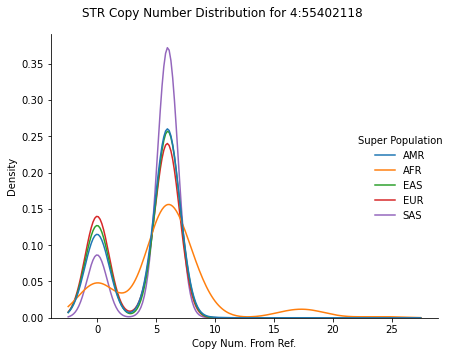

980 AMR
830 AFR
1170 EAS
1266 EUR
1202 SAS


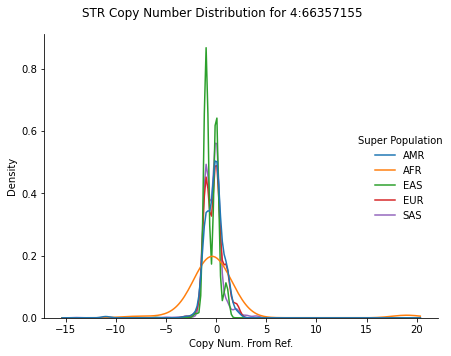

980 AMR
1550 AFR
1170 EAS
1264 EUR
1202 SAS


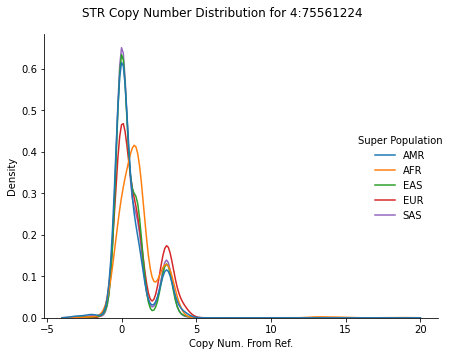

938 AMR
1736 AFR
818 EAS
182 EUR
674 SAS


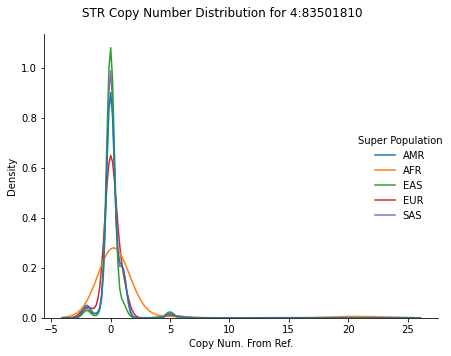

976 AMR
1778 AFR
1170 EAS
1264 EUR
1202 SAS


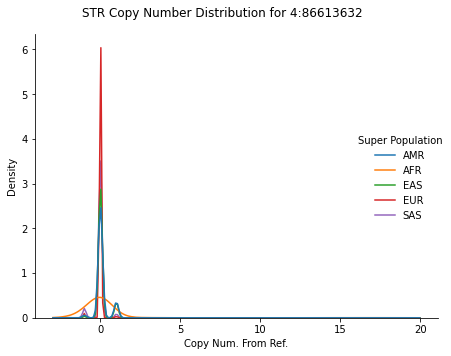

976 AMR
1782 AFR
1166 EAS
1264 EUR
1202 SAS


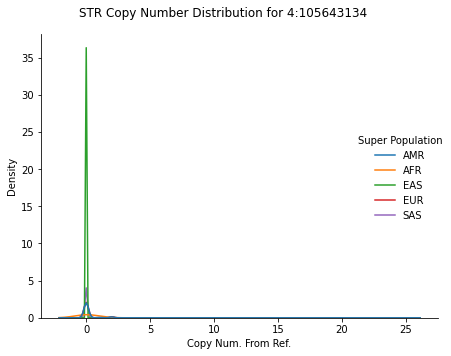

974 AMR
1756 AFR
1162 EAS
1262 EUR
1198 SAS


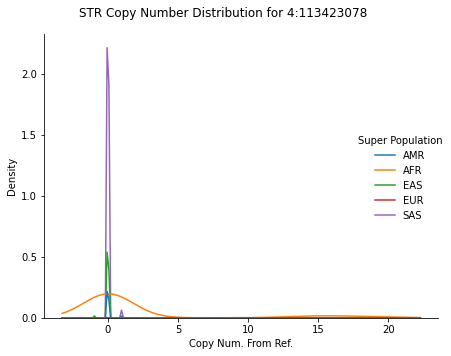

980 AMR
1718 AFR
1170 EAS
1264 EUR
1202 SAS


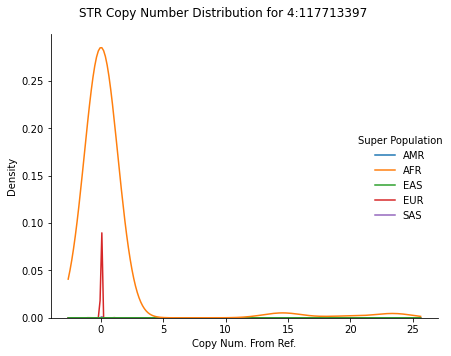

976 AMR
1776 AFR
1170 EAS
1264 EUR
1202 SAS


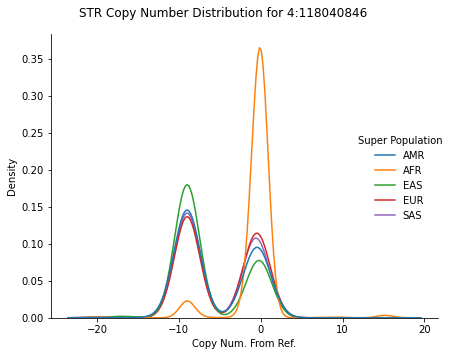

978 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


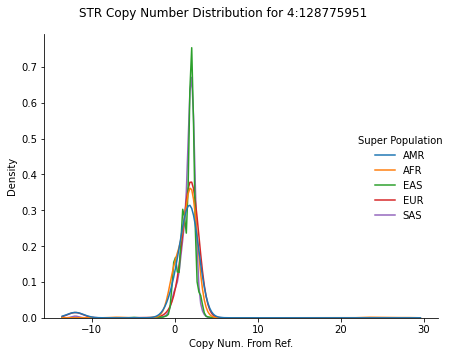

974 AMR
1766 AFR
1168 EAS
1258 EUR
1200 SAS


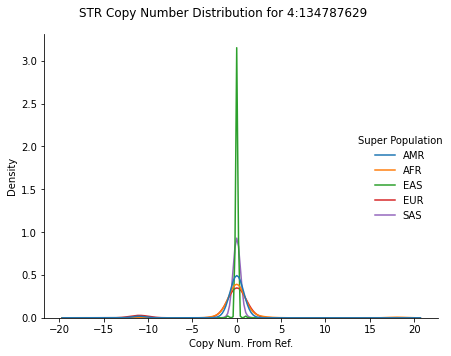

940 AMR
290 AFR
1146 EAS
1234 EUR
1166 SAS


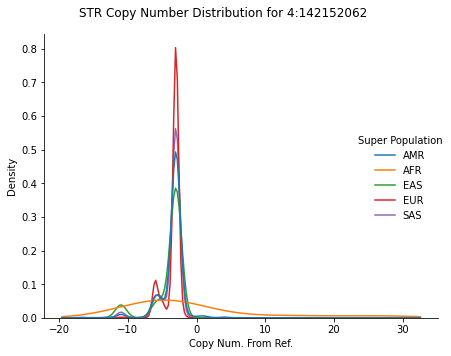

972 AMR
1722 AFR
1168 EAS
1264 EUR
1194 SAS


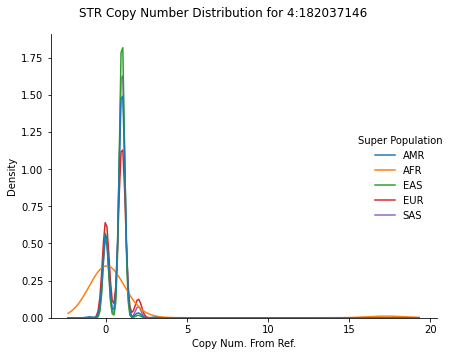

968 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


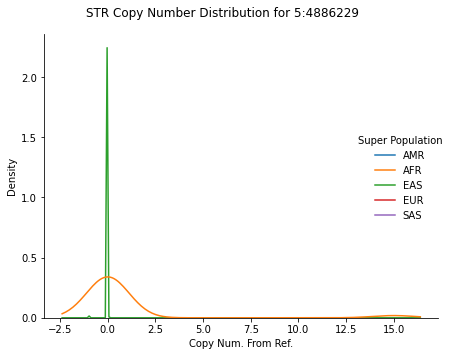

970 AMR
1700 AFR
1168 EAS
1262 EUR
1116 SAS


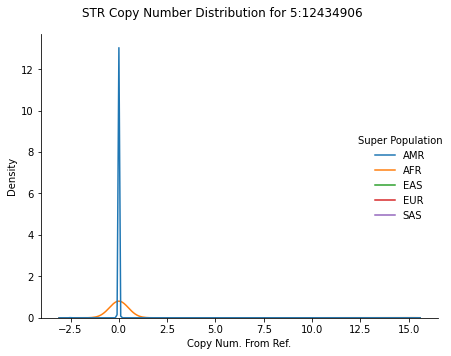

966 AMR
1618 AFR
1058 EAS
1246 EUR
1190 SAS


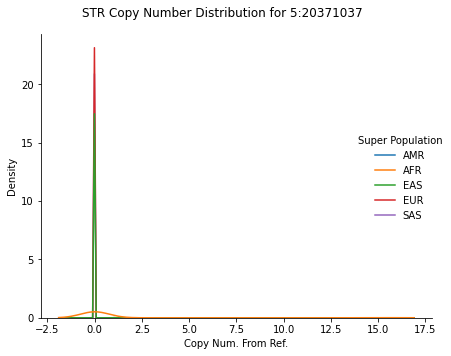

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


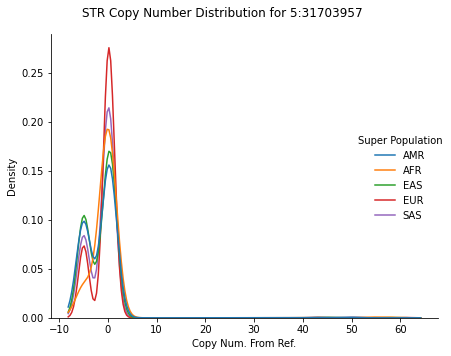

898 AMR
450 AFR
1148 EAS
1206 EUR
1174 SAS


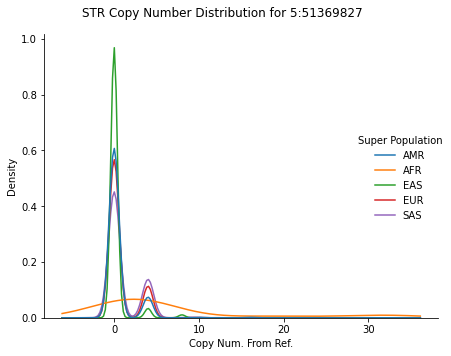

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


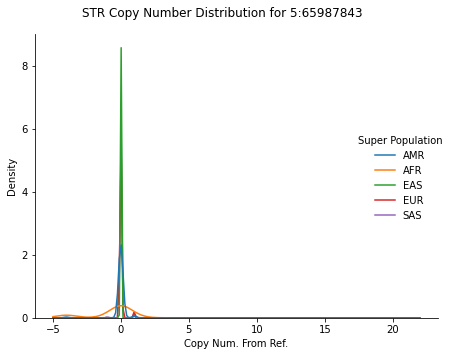

980 AMR
1764 AFR
1170 EAS
1266 EUR
1202 SAS


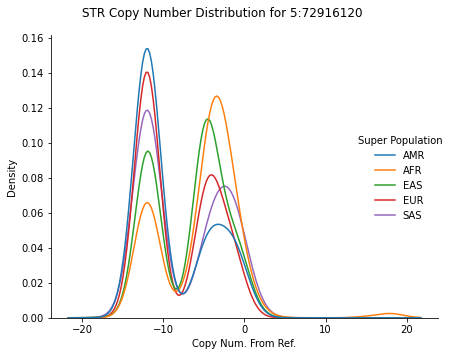

896 AMR
1082 AFR
1088 EAS
1164 EUR
1122 SAS


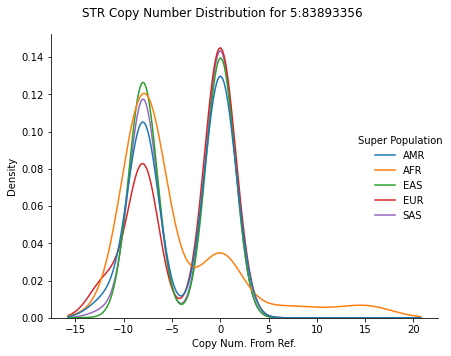

970 AMR
1766 AFR
1170 EAS
1266 EUR
1198 SAS


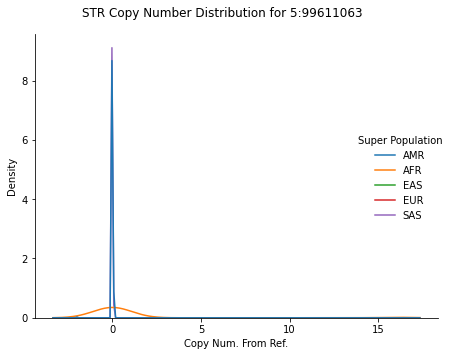

980 AMR
1430 AFR
1170 EAS
1266 EUR
1202 SAS


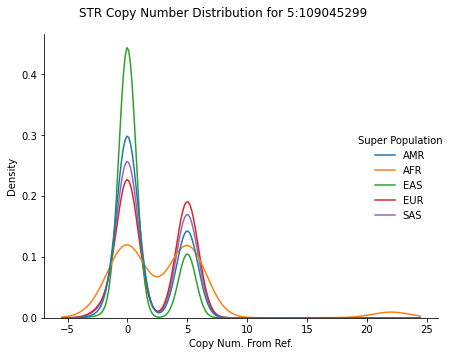

968 AMR
1716 AFR
1166 EAS
1266 EUR
1202 SAS


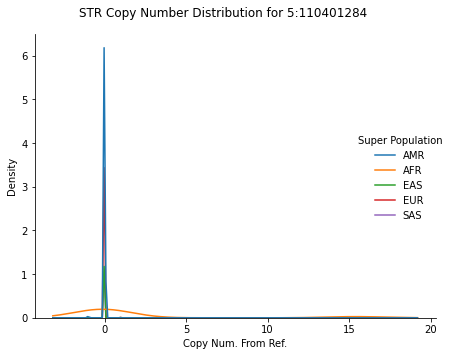

980 AMR
1760 AFR
1170 EAS
1266 EUR
1202 SAS


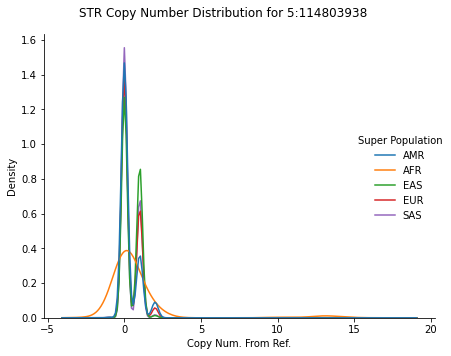

964 AMR
1712 AFR
1118 EAS
1246 EUR
1172 SAS


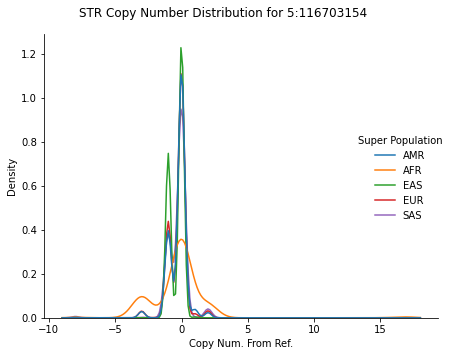

974 AMR
1756 AFR
1158 EAS
1262 EUR
1198 SAS


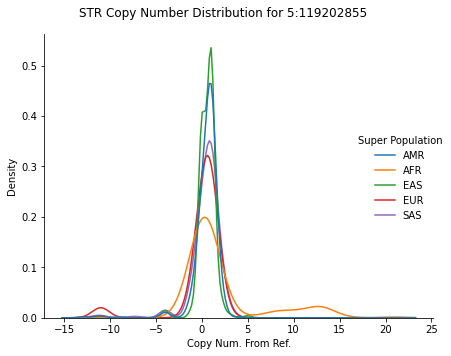

980 AMR
1032 AFR
1170 EAS
1266 EUR
1202 SAS


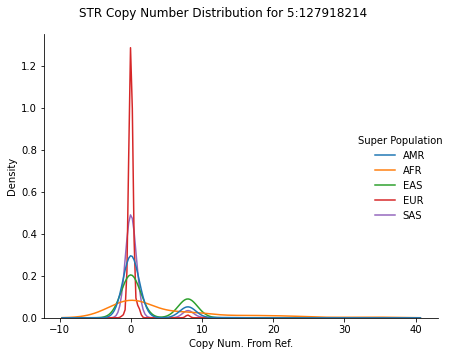

962 AMR
1694 AFR
1168 EAS
1266 EUR
1202 SAS


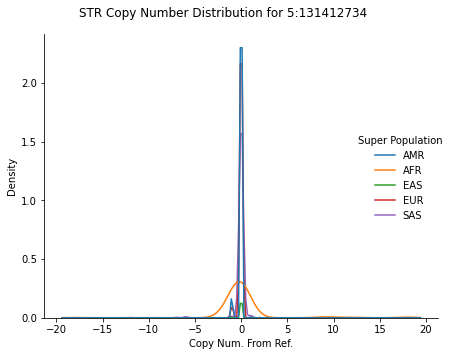

962 AMR
1586 AFR
1146 EAS
1228 EUR
1160 SAS


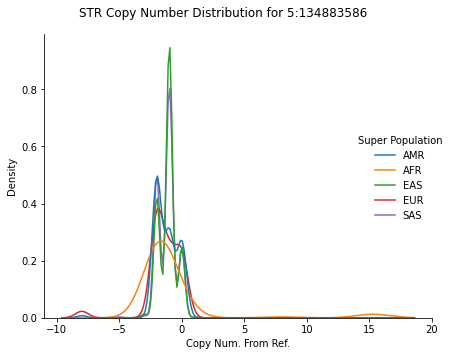

970 AMR
1660 AFR
1156 EAS
1252 EUR
1148 SAS


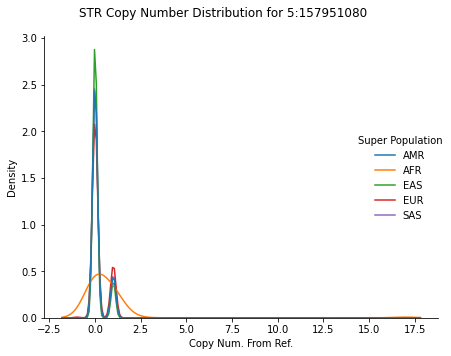

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


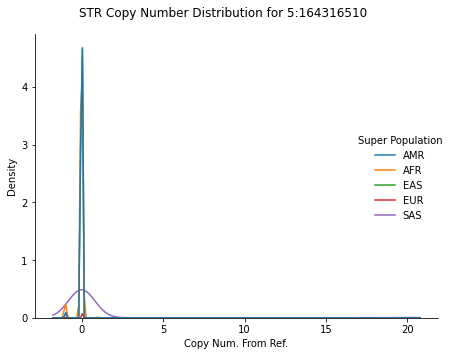

980 AMR
1782 AFR
1170 EAS
1264 EUR
1202 SAS


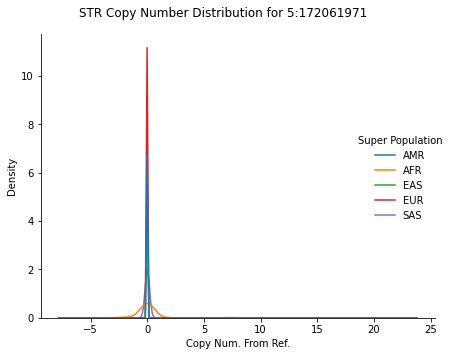

944 AMR
1598 AFR
1166 EAS
1264 EUR
1192 SAS


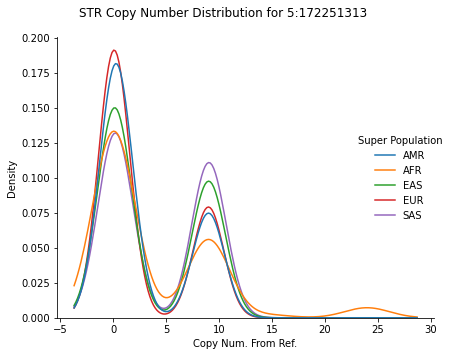

980 AMR
502 AFR
1086 EAS
1266 EUR
1202 SAS


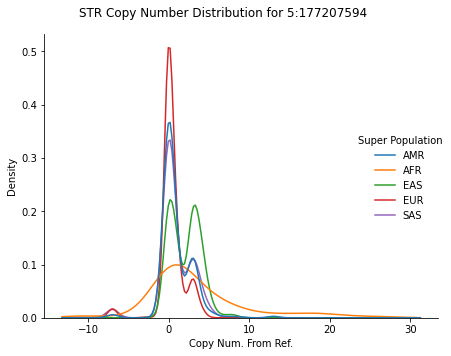

976 AMR
1766 AFR
1170 EAS
1264 EUR
1202 SAS


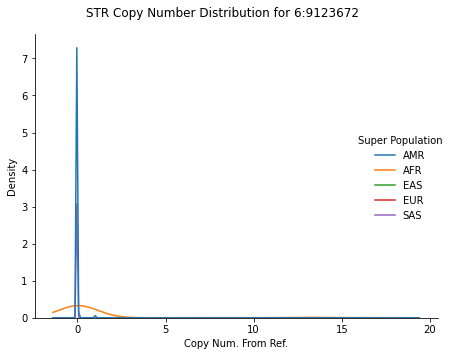

648 AMR
1436 AFR
670 EAS
1044 EUR
1052 SAS


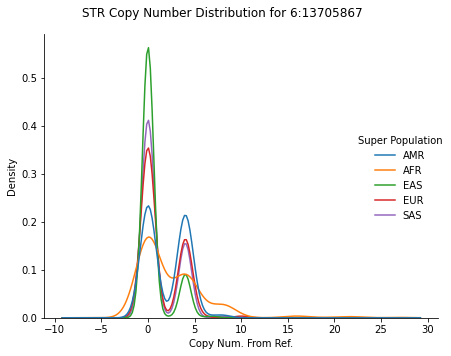

980 AMR
1600 AFR
1170 EAS
1266 EUR
1202 SAS


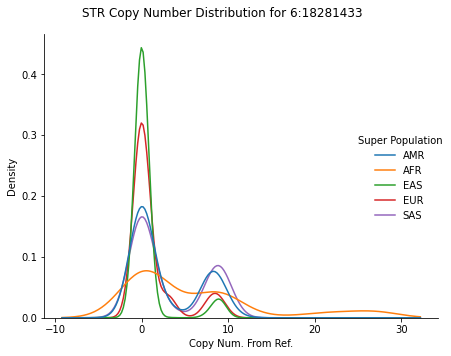

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


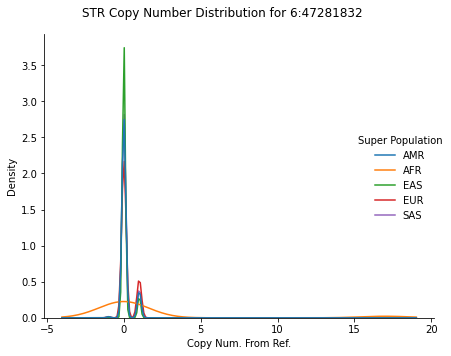

980 AMR
1720 AFR
1170 EAS
1266 EUR
1202 SAS


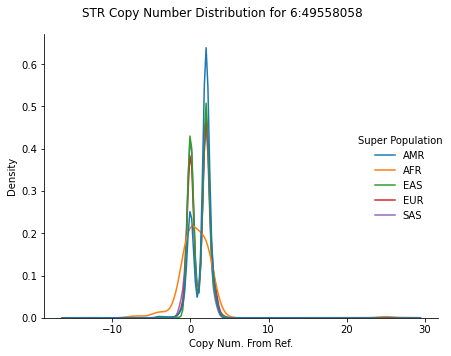

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


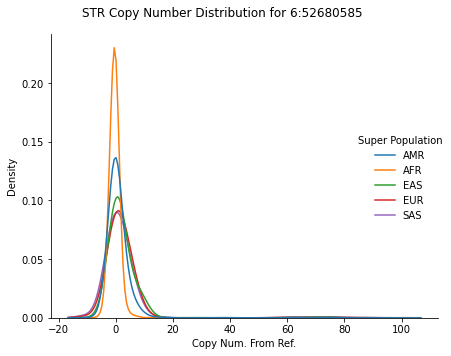

978 AMR
1730 AFR
1168 EAS
1264 EUR
1202 SAS


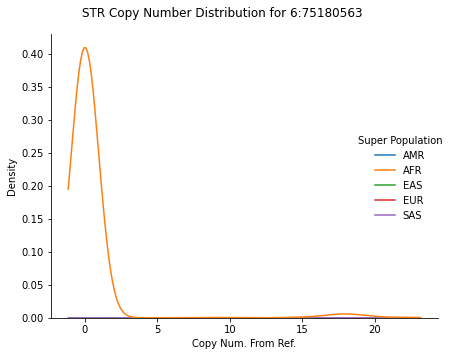

980 AMR
1730 AFR
1170 EAS
1262 EUR
1200 SAS


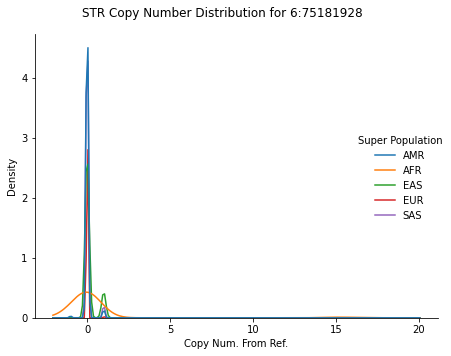

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


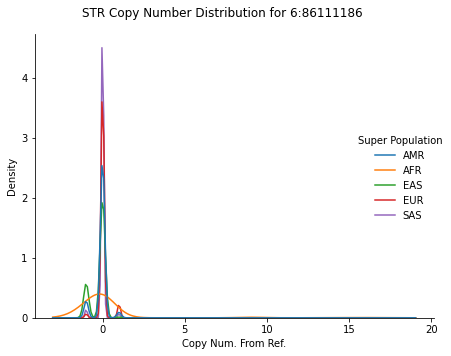

966 AMR
1638 AFR
1158 EAS
1260 EUR
1176 SAS


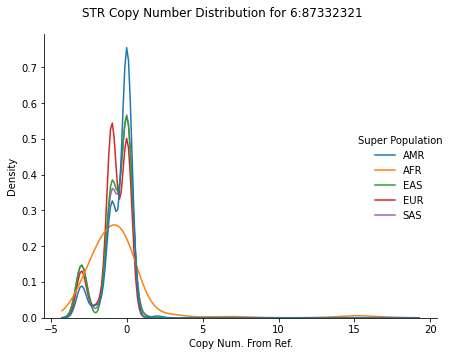

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


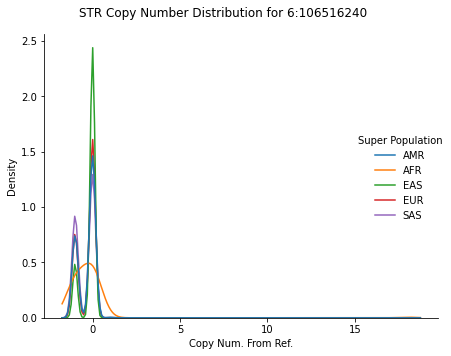

980 AMR
1774 AFR
1168 EAS
1266 EUR
1200 SAS


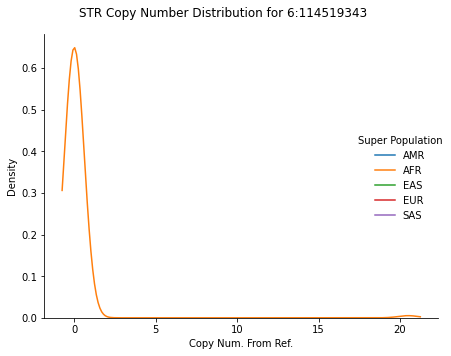

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


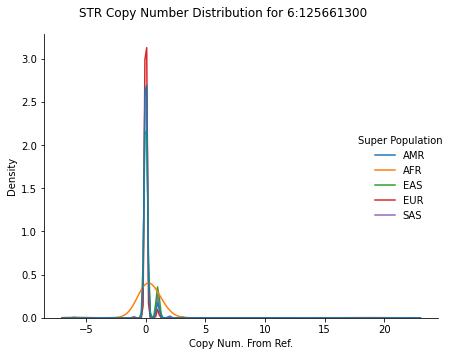

966 AMR
1616 AFR
1170 EAS
1264 EUR
1198 SAS


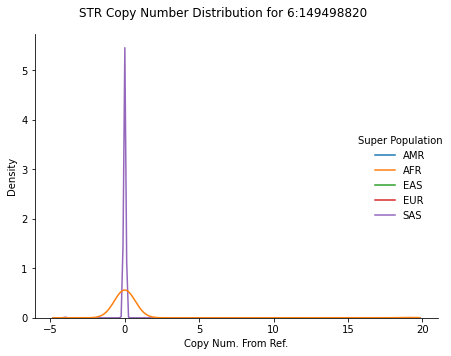

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


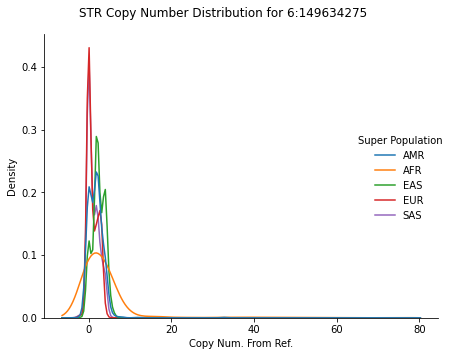

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


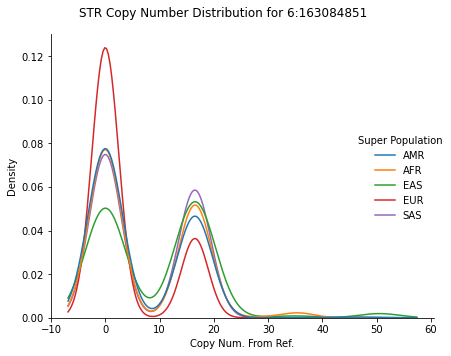

918 AMR
1632 AFR
1088 EAS
1108 EUR
1056 SAS


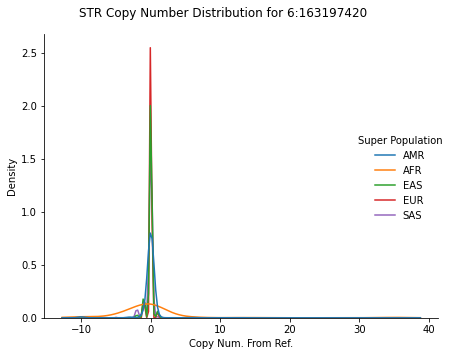

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


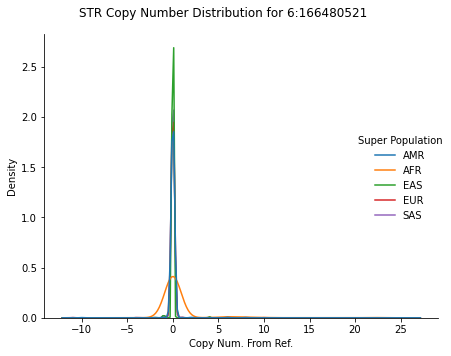

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


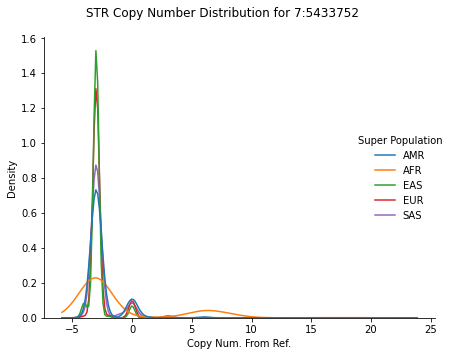

220 AMR
1680 AFR
1114 EAS
396 EUR
1024 SAS


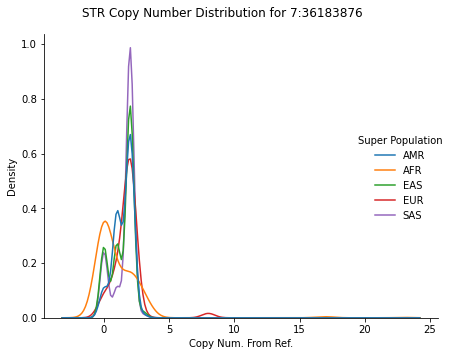

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


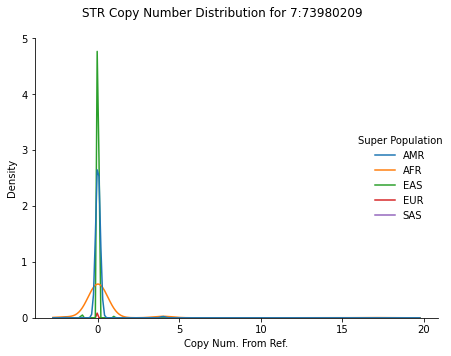

974 AMR
1778 AFR
1164 EAS
1258 EUR
1192 SAS


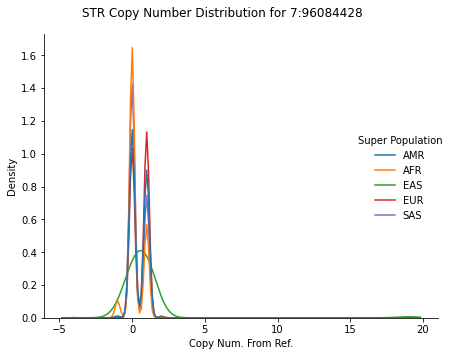

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


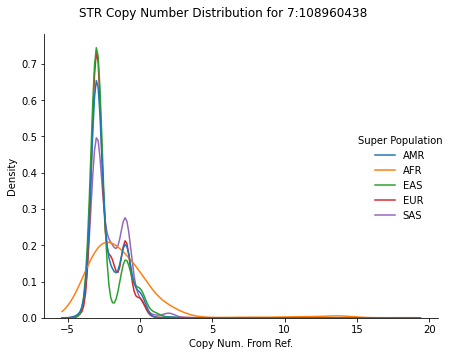

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


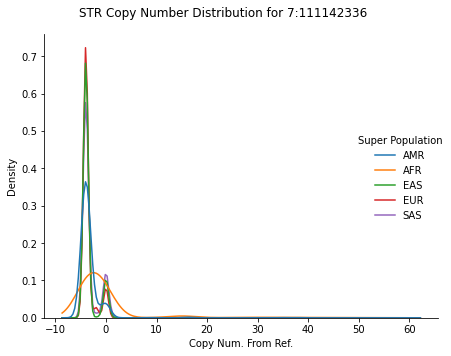

978 AMR
1124 AFR
1170 EAS
1266 EUR
1202 SAS


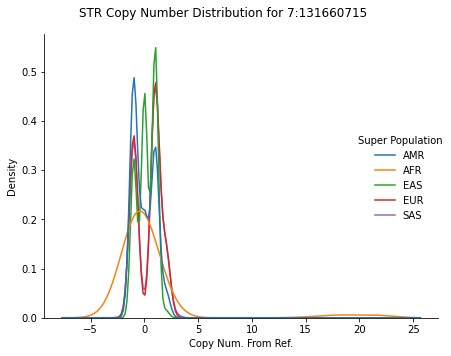

976 AMR
1722 AFR
1170 EAS
1266 EUR
1200 SAS


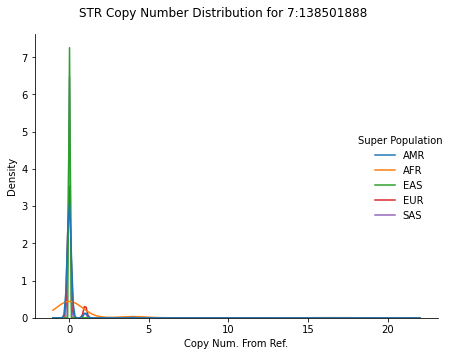

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


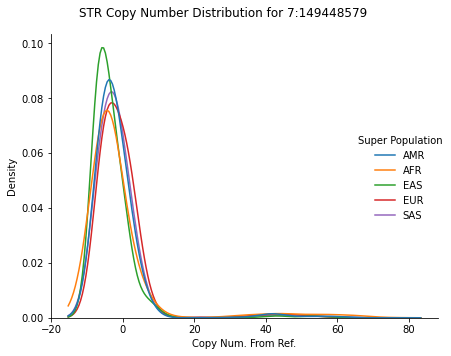

968 AMR
1552 AFR
1168 EAS
1254 EUR
1194 SAS


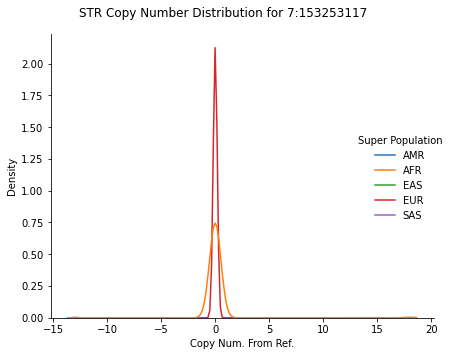

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


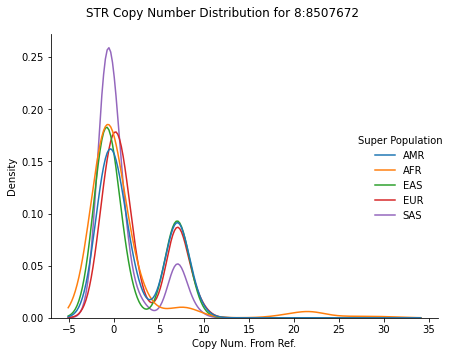

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


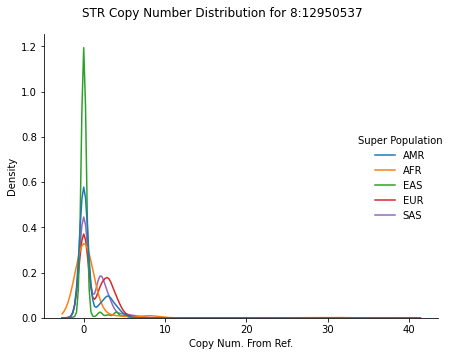

978 AMR
1700 AFR
1170 EAS
1262 EUR
1202 SAS


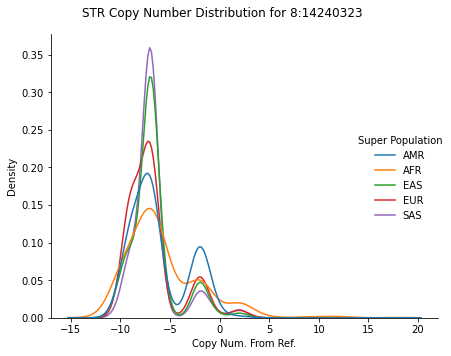

980 AMR
1784 AFR
1170 EAS
1266 EUR
1202 SAS


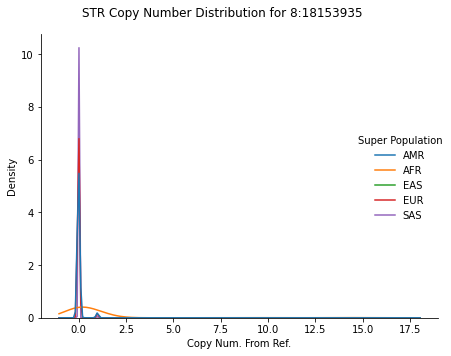

974 AMR
1750 AFR
1168 EAS
1250 EUR
1194 SAS


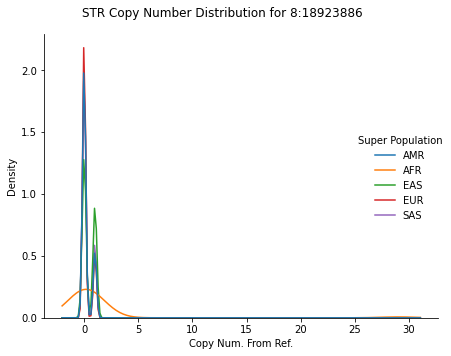

978 AMR
1734 AFR
1170 EAS
1266 EUR
1198 SAS


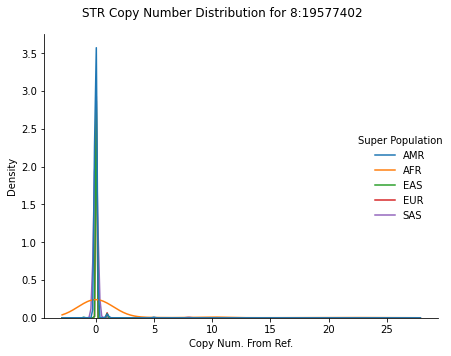

980 AMR
1054 AFR
1170 EAS
1266 EUR
1202 SAS


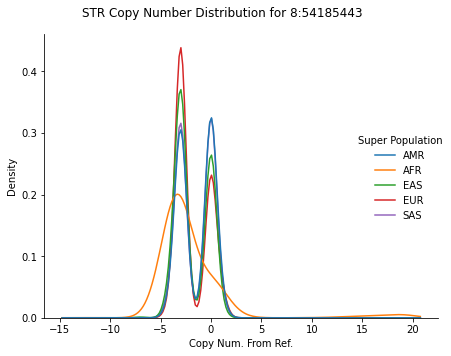

978 AMR
1782 AFR
1170 EAS
1264 EUR
1122 SAS


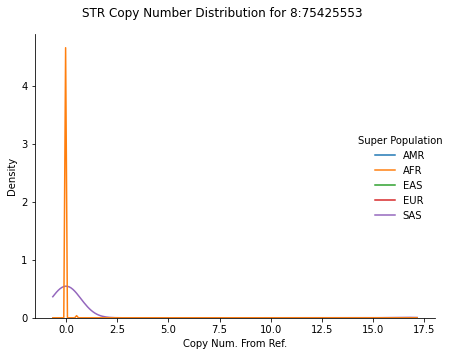

980 AMR
1780 AFR
1170 EAS
1266 EUR
1202 SAS


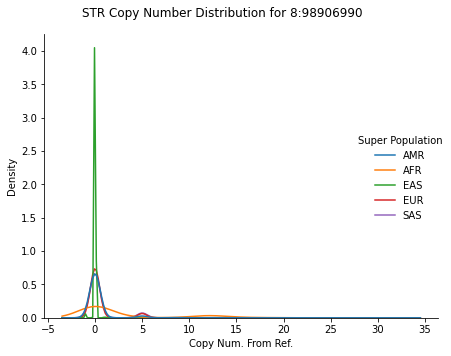

980 AMR
1752 AFR
1170 EAS
1266 EUR
1202 SAS


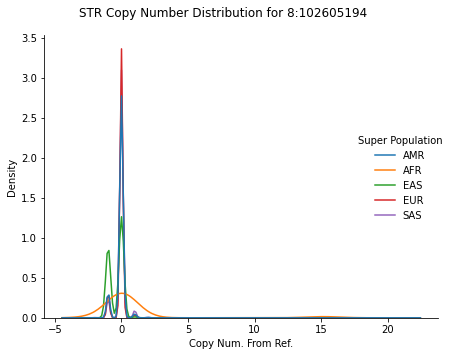

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


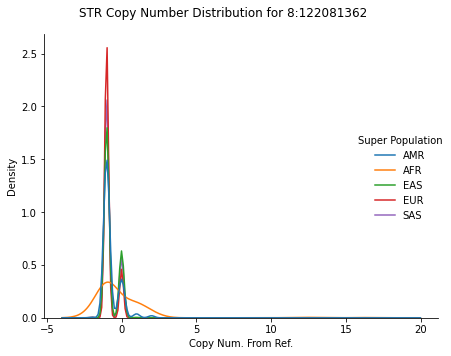

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


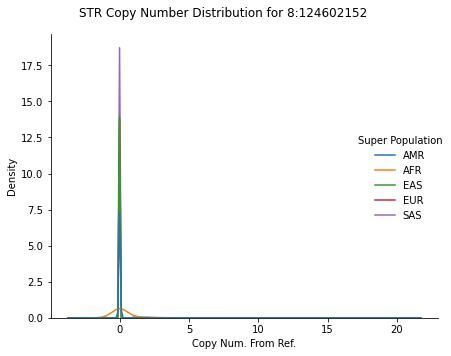

980 AMR
1782 AFR
1170 EAS
1266 EUR
1202 SAS


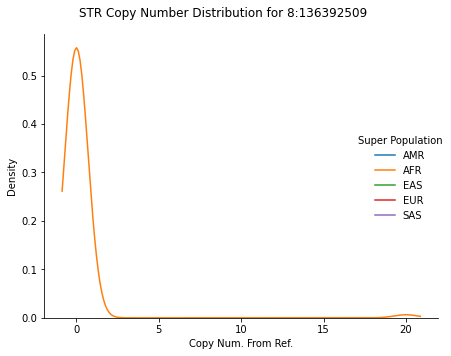

978 AMR
1568 AFR
1170 EAS
1264 EUR
1198 SAS


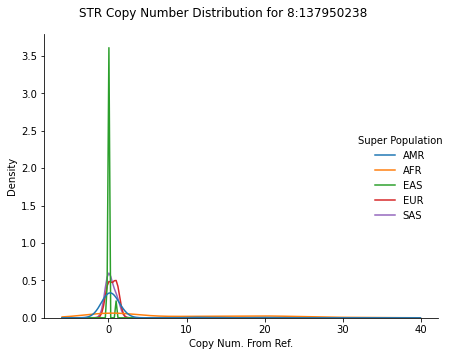

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


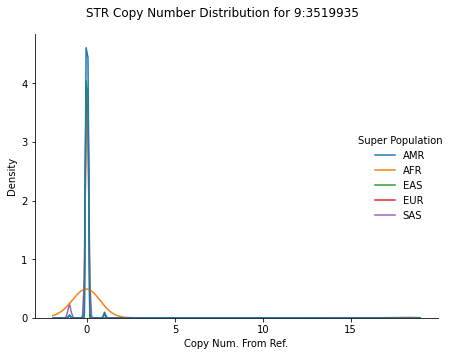

978 AMR
1766 AFR
1168 EAS
1262 EUR
1198 SAS


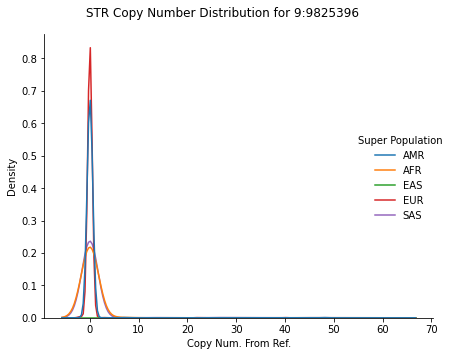

980 AMR
1786 AFR
1170 EAS
1266 EUR
1202 SAS


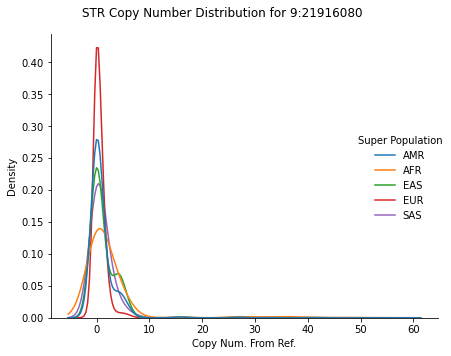

978 AMR
1770 AFR
1170 EAS
1266 EUR
1202 SAS


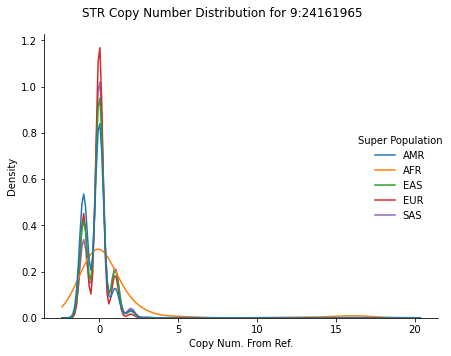

978 AMR
1730 AFR
1166 EAS
1262 EUR
1198 SAS


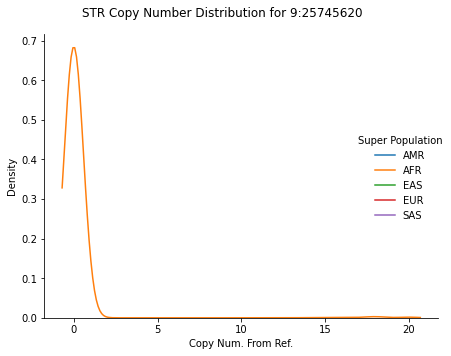

960 AMR
1688 AFR
1168 EAS
1264 EUR
1202 SAS


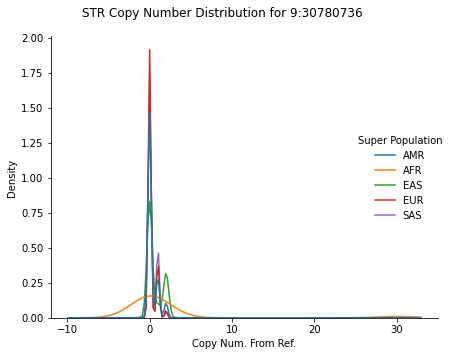

934 AMR
1702 AFR
1136 EAS
1180 EUR
1126 SAS


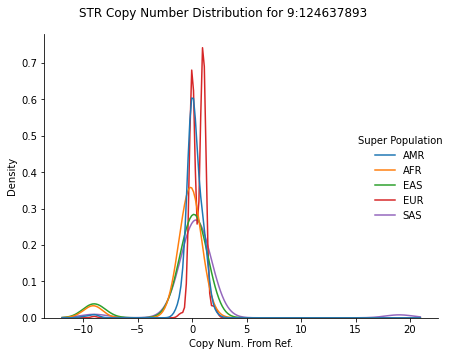

In [22]:
for index, row in both.iterrows():
    plot(row['chr'].replace("chr",""), row['pos'])